# US Recession Prediction Model


**Project Team**: Clayton Brossia, Lauren Jachimczyk, Jason Wang

## Project Overview

This project aims to develop a machine learning model that predicts the likelihood of a recession in the United States. Using historical economic indicators and recession data, we will explore various predictive techniques to determine which features are most influential and how effectively we can forecast economic downturns.

---

In [ ]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

!pip install -q kaggle
!pip install imbalanced-learn


## Download Data from Kaggle

1. Go to your Kaggle account settings.
2. Scroll down to the API section and click Create New API Token. This will download a kaggle.json file to your computer.
3. upload kaggle.json in the code block below

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"davidwebb249","key":"4eedad20366c89ab092f5cf934f99af0"}'}

In [ ]:
files.upload()

###REMOVING THIS DATASET
# # Download the US Recession Dataset (labeled data)
# !kaggle datasets download -d shubhaanshkumar/us-recession-dataset --unzip

# # Load the CSV file
labeldf = pd.read_csv("USREC.csv")

Saving USREC.csv to USREC (1).csv


5. following cell will download the data as csv files

In [ ]:
# Create a Kaggle directory and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Download the US Recession and Financial Indicators dataset (majority of our data)
!kaggle datasets download -d mikoajfish99/us-recession-and-financial-indicators --unzip

#Load all CSV files, skipping problematic lines
csv_files = glob.glob("*.csv")  # Adjust path if files are in a specific folder

dataframes = {}
for file in csv_files:
    try:
        df = pd.read_csv(file, on_bad_lines='skip')  # Skips problematic rows
        dataframes[file.split('/')[-1]] = df
        print(f"Loaded {file}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Display the names and first few rows of each DataFrame
for name, df in dataframes.items():
    print(f"--- {name} ---")
    print(df.head(), "\n")

Dataset URL: https://www.kaggle.com/datasets/mikoajfish99/us-recession-and-financial-indicators
License(s): ODbL-1.0
  0% 0.00/0.99M [00:00<?, ?B/s]
100% 0.99M/0.99M [00:00<00:00, 25.4MB/s]
Loaded Bank Credit All Commercial Banks.csv
Loaded Federal Funds Effective Rate.csv
Loaded Households Owners Equity in Real Estate Level.csv
Loaded Sticky Price Consumer Price Index less Food and Energy.csv
Loaded DGS2.csv
Loaded Personal Saving Rate.csv
Loaded Continued Claims (Insured Unemployment).csv
Loaded USREC (1).csv
Loaded Sticky Price Consumer Price Index.csv
Loaded DGS10.csv
Loaded Gross Domestic Product.csv
Loaded Consumer Loans Credit Cards and Other Revolving Plans All Commercial Banks.csv
Loaded USREC.csv
Loaded Unemployment Rate.csv
Loaded NASDAQ.csv
Loaded Delinquency Rate on Credit Card Loans All Commercial Banks.csv
Loaded Commercial Real Estate Prices for United States.csv
Loaded Consumer Price Index Total All Items for the United States.csv
Loaded Real Estate Loans Commercial Re

In [ ]:
labeldf

,DATE,USREC
0,1854-12-01,1
1,1855-01-01,0
2,1855-02-01,0
3,1855-03-01,0
4,1855-04-01,0
...,...,...
2035,2024-07-01,0
2036,2024-08-01,0
2037,2024-09-01,0
2038,2024-10-01,0


## Data Pre-Processing

### Metadata

Collecting the metadata for all of our datasets

In [ ]:
metadata_df = []
metadata = []

#delete us_recession.csv since we have it stored as a dataframe as well
for file in list(dataframes.keys()):
    if re.match(r'(USREC|DGS(10|2))(?: \(\d+\))?\.csv', file): #exclude label csv and yield curve csv since they are handled separately
        del dataframes[file]

#function to detect timeframe based on date differences
def detect_timeframe(date_series):
    date_diffs = date_series.diff().dropna()
    if date_diffs.min().days >= 365:
        return 'Yearly'
    elif date_diffs.min().days >= 90:
        return 'Quarterly'
    elif date_diffs.min().days >= 28:
        return 'Monthly'
    elif date_diffs.min().days >= 7:
        return 'Weekly'
    else:
        return 'Daily'

#Process each DataFrame in the dataframes dictionary
for name, df in dataframes.items():
    # Convert all column names to uppercase
    df.columns = [col.upper() for col in df.columns]

    #Ensure the DATE column is in datetime format and determine min and max dates
    if 'DATE' in df.columns:
        df['DATE'] = pd.to_datetime(df['DATE'])
        min_date = df['DATE'].min()
        max_date = df['DATE'].max()
        timeframe = detect_timeframe(df['DATE'])
    else:
        min_date = None
        max_date = None
        timeframe = None

    #Append metadata for this file
    metadata.append({
        "File_Name": name,
        "Columns": df.columns.tolist(),
        "min_date": min_date,
        "max_date": max_date,
        "timeframe": timeframe
    })

#Process the labeldf
labeldf.columns = [col.upper() for col in labeldf.columns]
if 'DATE' in labeldf.columns:
    labeldf['DATE'] = pd.to_datetime(labeldf['DATE'])
    min_date = labeldf['DATE'].min()
    max_date = labeldf['DATE'].max()
    timeframe = detect_timeframe(labeldf['DATE'])
else:
    min_date = None
    max_date = None
    timeframe = None

#Append metadata for labeldf
metadata.append({
    "File_Name": "labeldf",
    "Columns": labeldf.columns.tolist(),
    "min_date": min_date,
    "max_date": max_date,
    "timeframe": timeframe
})

#Convert metadata list to a DataFrame
metadata_df = pd.DataFrame(metadata)

metadata_df

,File_Name,Columns,min_date,max_date,timeframe
0,Bank Credit All Commercial Banks.csv,"[DATE, TOTBKCR]",1973-01-03,2023-04-19,Weekly
1,Federal Funds Effective Rate.csv,"[DATE, DFF]",1954-07-01,2023-05-02,Daily
2,Households Owners Equity in Real Estate Level.csv,"[DATE, OEHRENWBSHNO]",1945-10-01,2022-10-01,Quarterly
3,Sticky Price Consumer Price Index less Food an...,"[DATE, CORESTICKM159SFRBATL]",1967-12-01,2023-03-01,Monthly
4,Personal Saving Rate.csv,"[DATE, PSAVERT]",1959-01-01,2023-03-01,Monthly
5,Continued Claims (Insured Unemployment).csv,"[DATE, CCSA]",1967-01-07,2023-04-15,Weekly
6,Sticky Price Consumer Price Index.csv,"[DATE, STICKCPIM157SFRBATL]",1967-01-01,2023-03-01,Monthly
7,Gross Domestic Product.csv,"[DATE, GDP]",1947-01-01,2023-01-01,Quarterly
8,Consumer Loans Credit Cards and Other Revolvin...,"[DATE, CCLACBW027SBOG]",2000-06-28,2023-04-19,Weekly
9,Unemployment Rate.csv,"[DATE, UNRATE]",1948-01-01,2023-04-01,Monthly


### Visualize Timeframes

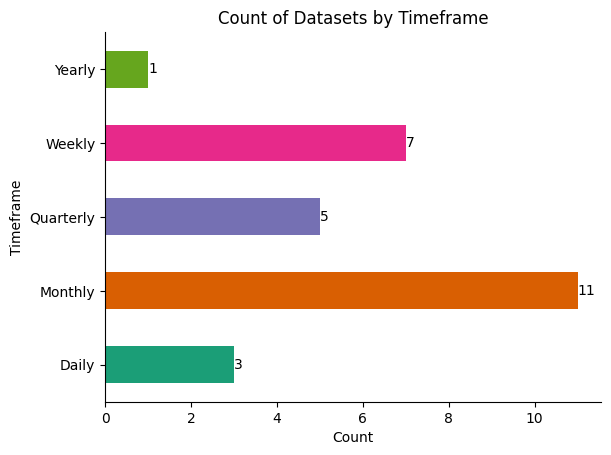

In [ ]:
#Plot with data labels
ax = metadata_df.groupby('timeframe').size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

#Add data labels to each bar
for index, value in enumerate(metadata_df.groupby('timeframe').size()):
    plt.text(value, index, str(value), va='center')

plt.xlabel("Count")
plt.ylabel("Timeframe")
plt.title("Count of Datasets by Timeframe")
plt.show()

### Data Combination
We now need to combine all of the data into 1 dataframe. Since the various datasets have different timeframes, we will convert to a common format. Data will be based on monthly values, because the majority of our datasets (11) are already on a monthly basis, including our labeled recession indicator data.

### Why Use Monthly as the Standard Timeframe?
1. **Economic and Financial Analysis:** Monthly data is widely used in economic and financial analysis to balance detail with noise reduction, which is crucial when predicting economic phenomena like recessions.
2. **Availability of Label Data:** Since our recession indicator is already on a monthly basis, this will align all data with our target variable’s timeframe.
3. **Preserving Trends:** Monthly data is detailed enough to capture trends, but avoids excessive noise that daily or weekly data may introduce.

### Standardize Different Timeframes to Monthly
3 of our csvs are on a daily basis, 7 on a weekly basis, 5 on a quarterly basis, and 1 on a yearly basis. Here is how we are converting them to a monthly timeframe
1. **Daily Data:** Convert to monthly by taking the last value of each month, representing an end-of-month snapshot, which is common practice in financial reporting.
2. **Weekly Data:** Convert to monthly by using the last weekly value in each month.
3. **Quarterly**: Resample to monthly by forward-filling each value to apply it across the three months, which keeps quarterly data available on a rolling basis.
4. **Yearly Data:** Forward-fill each yearly value across all months within the year.

In [ ]:
#Define the resampling rules based on frequency
for name, df in dataframes.items():
    #Ensure all column names are uppercase for consistency
    df.columns = [col.upper() for col in df.columns]

    #Ensure DATE column is in datetime format
    df['DATE'] = pd.to_datetime(df['DATE'])

    #Identify the timeframe for each file based on metadata and apply appropriate resampling
    timeframe = metadata_df.loc[metadata_df['File_Name'] == name, 'timeframe'].values[0]

    if timeframe == 'Daily':
        # Daily data: take the last value of each month
        dataframes[name] = df.set_index('DATE').resample('M').last().reset_index()
    elif timeframe == 'Weekly':
        # Weekly data: take the last weekly value in each month
        dataframes[name] = df.set_index('DATE').resample('M').last().reset_index()
    elif timeframe == 'Quarterly':
        # Quarterly data: forward-fill to apply each value across the following two months
        dataframes[name] = df.set_index('DATE').resample('M').ffill().reset_index()
    elif timeframe == 'Yearly':
        # Yearly data: forward-fill each yearly value across all months within the year
        dataframes[name] = df.set_index('DATE').resample('M').ffill().reset_index()
    else:
        # If already monthly, keep as-is
        dataframes[name] = df

# Now that all datasets are resampled to monthly, we will merge
#Initialize recession_df with labeldf as the base DataFrame (since it's already monthly)
recession_df = labeldf

#Merge each DataFrame in the dataframes dictionary with recession_df
for name, df in dataframes.items():
    if name != "labeldf":  #Skip labeldf if it’s already in recession_df
        recession_df = pd.merge(recession_df, df, on='DATE', how='outer')

#Sort by DATE and forward-fill any remaining missing values
recession_df.sort_values('DATE', inplace=True)
recession_df.fillna(method='ffill', inplace=True)

#After merging, set DATE as the index and resample to ensure only the last day of each month remains
recession_df = recession_df.set_index('DATE').resample('M').last().reset_index()

recession_df

<ipython-input-9-d7ec942ccb67>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dataframes[name] = df.set_index('DATE').resample('M').last().reset_index()
<ipython-input-9-d7ec942ccb67>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dataframes[name] = df.set_index('DATE').resample('M').last().reset_index()
<ipython-input-9-d7ec942ccb67>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dataframes[name] = df.set_index('DATE').resample('M').ffill().reset_index()
<ipython-input-9-d7ec942ccb67>:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dataframes[name] = df.set_index('DATE').resample('M').last().reset_index()
<ipython-input-9-d7ec942ccb67>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dataframes[name] = 

,DATE,USREC,TOTBKCR,DFF,OEHRENWBSHNO,CORESTICKM159SFRBATL,PSAVERT,CCSA,STICKCPIM157SFRBATL,GDP,...,VOL._y,CHANGE %_y,WM1NS,CPIAUCSL,REAINTRATREARAT10Y,MEDCPIM158SFRBCLE,WM2NS,FPCPITOTLZGUSA,RHEACBW027SBOG_y,U6RATE
0,1854-12-31,1.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1855-01-31,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1855-02-28,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1855-03-31,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1855-04-30,0.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,2024-07-31,0.0,17334.9846,4.83,30981.345,6.451708,5.1,1858000.0,0.383314,26465.865,...,NaN,-0.70%,18895.2,301.808,1.439817,4.907055,20877.6,4.697859,254.8838,6.7
2036,2024-08-31,0.0,17334.9846,4.83,30981.345,6.451708,5.1,1858000.0,0.383314,26465.865,...,NaN,-0.70%,18895.2,301.808,1.439817,4.907055,20877.6,4.697859,254.8838,6.7
2037,2024-09-30,0.0,17334.9846,4.83,30981.345,6.451708,5.1,1858000.0,0.383314,26465.865,...,NaN,-0.70%,18895.2,301.808,1.439817,4.907055,20877.6,4.697859,254.8838,6.7
2038,2024-10-31,0.0,17334.9846,4.83,30981.345,6.451708,5.1,1858000.0,0.383314,26465.865,...,NaN,-0.70%,18895.2,301.808,1.439817,4.907055,20877.6,4.697859,254.8838,6.7


In [ ]:
recession_df.columns.tolist()
recession_df.shape

(2040, 38)

Visualizing frequency of NaN values to find a date range to use for the model

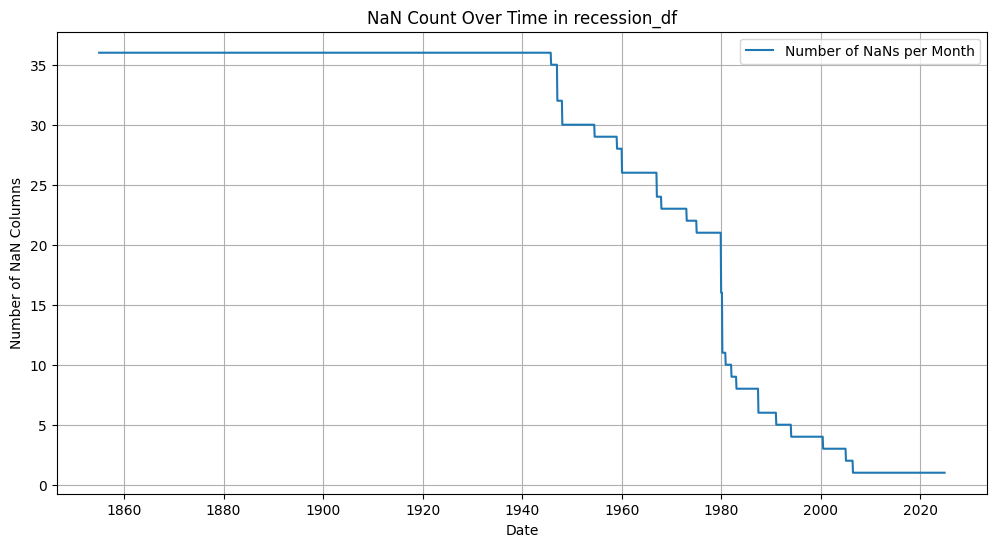

In [ ]:
# Count the number of NaN values for each row in recession_df
recession_df['NaN_Count'] = recession_df.isna().sum(axis=1)

# Plot NaN count over time
plt.figure(figsize=(12, 6))
plt.plot(recession_df['DATE'], recession_df['NaN_Count'], label='Number of NaNs per Month')
plt.xlabel('Date')
plt.ylabel('Number of NaN Columns')
plt.title('NaN Count Over Time in recession_df')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, remove the 'NaN_Count' column after plotting
recession_df.drop(columns=['NaN_Count'], inplace=True)

In the early 1980s, there is a sharp decline in the amount of NaN values. For our model, we will limit our datarange to begin at January 1983. We will also limit the dataset's max date to January 2021. Based on the metadata, this appears to be the minimum of each feature's max date. Although we'd prefer a longer period of time, based on our analysis 1983-2021 has the most complete set of values for us to work with. Let's see which columns we need to remove, since they have NaN values after this cut off.

In [ ]:
#Filter recession_df to include only rows from January 1983 onwards
filtered_df = recession_df[(recession_df['DATE'] >= '1983-01-01') & (recession_df['DATE'] <= '2021-01-01')]

#Identify columns that have any NaN values in the filtered range
columns_with_nans = filtered_df.isna().any()
columns_with_nans = columns_with_nans[columns_with_nans].index.tolist()

print("Columns with NaN values post Jan 1983:", columns_with_nans)

Columns with NaN values post Jan 1983: ['CCLACBW027SBOG', 'VOL._x', 'DRCCLACBS', 'COMREPUSQ159N', 'RHEACBW027SBOG_x', 'VOL._y', 'RHEACBW027SBOG_y', 'U6RATE']


In [ ]:
#Look at metadata to see which columns these are with missing data
files_with_nan_columns = metadata_df[metadata_df['Columns'].apply(lambda cols: any(col in columns_with_nans for col in cols))]

print("Files with columns that have NaN values post-1983:")
print(files_with_nan_columns[['File_Name', 'Columns']])

Files with columns that have NaN values post-1983:
                                            File_Name                 Columns
8   Consumer Loans Credit Cards and Other Revolvin...  [DATE, CCLACBW027SBOG]
11  Delinquency Rate on Credit Card Loans All Comm...       [DATE, DRCCLACBS]
12  Commercial Real Estate Prices for United State...   [DATE, COMREPUSQ159N]
25  Total Unemployed Plus All Persons Marginally A...          [DATE, U6RATE]


Commercial real estate prices starts in 2005. Consumer loan starts in 2000. Total unemployed plus starts in 1994.

In [ ]:
# Drop these columns from the original recession_df
df = filtered_df.drop(columns=columns_with_nans)

df

,DATE,USREC,TOTBKCR,DFF,OEHRENWBSHNO,CORESTICKM159SFRBATL,PSAVERT,CCSA,STICKCPIM157SFRBATL,GDP,...,OPEN_y,HIGH_y,LOW_y,CHANGE %_y,WM1NS,CPIAUCSL,REAINTRATREARAT10Y,MEDCPIM158SFRBCLE,WM2NS,FPCPITOTLZGUSA
1537,1983-01-31,0.0,1396.8702,8.56,2474.362,4.695598,11.1,3890000.0,0.51170,3473.413,...,144.50,146.10,143.00,0.55%,467.5,97.900,5.543389,5.014653,1963.5,3.212435
1538,1983-02-28,0.0,1400.5734,8.53,2474.362,4.627836,11.1,3876000.0,0.35447,3473.413,...,149.70,150.30,146.90,-1.07%,472.5,98.000,5.861705,4.952545,1989.0,3.212435
1539,1983-03-31,0.0,1420.6188,10.81,2474.362,4.855813,10.6,3734000.0,0.23015,3473.413,...,153.40,156.40,152.30,-0.26%,476.3,98.100,5.573838,3.612261,2006.0,3.212435
1540,1983-04-30,0.0,1430.1645,8.84,2494.423,4.456934,10.3,3722000.0,0.52142,3578.848,...,162.90,165.40,161.90,0.92%,492.2,98.800,5.700122,4.828054,2022.9,3.212435
1541,1983-05-31,0.0,1441.6828,8.94,2494.423,3.549624,9.9,3457000.0,0.22823,3578.848,...,164.50,164.70,161.20,-1.28%,488.6,99.200,5.402394,3.767326,2031.0,3.212435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,2020-08-31,0.0,14920.2229,0.09,21175.542,2.288978,15.5,13501000.0,0.24904,21362.428,...,"3,509.73","3,514.77","3,493.25",-0.22%,16944.9,259.411,-0.407134,2.235723,18376.9,1.233584
1989,2020-09-30,0.0,14944.5599,0.09,21175.542,2.077391,14.6,10481000.0,0.02761,21362.428,...,"3,341.21","3,393.56","3,340.47",0.83%,17098.6,260.029,-0.343337,1.133933,18488.3,1.233584
1990,2020-10-31,0.0,14953.9365,0.09,21985.897,1.842159,14.0,6705000.0,0.08769,21704.706,...,"3,293.59","3,304.93","3,233.94",-1.21%,17279.3,260.286,-0.291738,1.838456,18640.9,1.233584
1991,2020-11-30,0.0,15007.3724,0.09,21985.897,1.798587,13.3,5784000.0,0.20720,21704.706,...,"3,634.18","3,634.18","3,594.39",-0.46%,17729.5,260.813,-0.213956,1.218911,19049.9,1.233584


In [ ]:
columns = df.columns.tolist()
print("Columns in df:")
print(columns)

Columns in df:
['DATE', 'USREC', 'TOTBKCR', 'DFF', 'OEHRENWBSHNO', 'CORESTICKM159SFRBATL', 'PSAVERT', 'CCSA', 'STICKCPIM157SFRBATL', 'GDP', 'UNRATE', 'PRICE_x', 'OPEN_x', 'HIGH_x', 'LOW_x', 'CHANGE %_x', 'CPALTT01USM657N', 'UNEMPLOY', 'GDPC1', 'PRICE_y', 'OPEN_y', 'HIGH_y', 'LOW_y', 'CHANGE %_y', 'WM1NS', 'CPIAUCSL', 'REAINTRATREARAT10Y', 'MEDCPIM158SFRBCLE', 'WM2NS', 'FPCPITOTLZGUSA']


# Exploratory Data Analysis

In [ ]:
df.describe()

,DATE,USREC,TOTBKCR,DFF,CORESTICKM159SFRBATL,PSAVERT,CCSA,STICKCPIM157SFRBATL,GDP,UNRATE,CPALTT01USM657N,UNEMPLOY,GDPC1,WM1NS,CPIAUCSL,REAINTRATREARAT10Y,MEDCPIM158SFRBCLE,WM2NS,FPCPITOTLZGUSA
count,456,456.000000,456.000000,456.000000,456.000000,456.000000,4.560000e+02,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,2002-01-14 09:28:25.263157888,0.078947,6242.663672,3.946754,3.057634,7.180482,2.984434e+06,0.248775,11440.984309,6.094079,0.215986,8556.936404,13147.506132,1864.896711,180.047675,2.448516,2.891306,6683.581798,2.636966
min,1983-01-31 00:00:00,0.000000,1396.870200,0.040000,0.667614,2.100000,1.508000e+06,-0.162080,3473.413000,3.500000,-1.915290,5481.000000,6896.561000,467.500000,97.900000,-0.407134,-0.286064,1963.500000,-0.355546
25%,1992-07-23 06:00:00,0.000000,2808.215375,0.912500,2.244801,5.675000,2.253750e+06,0.179512,6542.671500,4.875000,0.057998,6867.500000,9715.362000,943.950000,140.400000,0.913656,2.218789,3385.250000,1.812210
50%,2002-01-15 12:00:00,0.000000,5045.750050,3.925000,2.739851,7.000000,2.595500e+06,0.229772,10721.982500,5.700000,0.225416,7927.000000,13348.152000,1187.550000,177.850000,2.314008,2.816846,5431.150000,2.741328
75%,2011-07-07 18:00:00,0.000000,9056.768425,6.092500,3.590640,8.500000,3.229250e+06,0.306113,15580.071500,7.125000,0.404379,9095.000000,15872.222750,2013.675000,224.953250,3.630495,3.460440,9140.625000,3.376857
max,2020-12-31 00:00:00,1.000000,15056.957100,14.350000,5.948660,33.800000,2.175000e+07,0.668930,21706.532000,14.700000,1.221996,23050.000000,19215.691000,17999.400000,262.035000,7.446144,5.814260,19292.300000,5.397956
std,NaN,0.269953,3822.636865,3.215341,1.130093,2.745913,1.812152e+06,0.109164,5365.158082,1.720487,0.311888,2550.699918,3556.434514,2262.854180,48.260633,1.741337,1.081646,4109.232891,1.179696


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 1537 to 1992
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  456 non-null    datetime64[ns]
 1   USREC                 456 non-null    float64       
 2   TOTBKCR               456 non-null    float64       
 3   DFF                   456 non-null    float64       
 4   OEHRENWBSHNO          456 non-null    object        
 5   CORESTICKM159SFRBATL  456 non-null    float64       
 6   PSAVERT               456 non-null    float64       
 7   CCSA                  456 non-null    float64       
 8   STICKCPIM157SFRBATL   456 non-null    float64       
 9   GDP                   456 non-null    float64       
 10  UNRATE                456 non-null    float64       
 11  PRICE_x               456 non-null    object        
 12  OPEN_x                456 non-null    object        
 13  HIGH_x               

We have now verified that we have a complete dataset, with no columns having any null values. We do, however, have some features with non-numeric data types. After examining the data, it is clear that Price, Open, High and Low are all numeric but may have been stored as strings in the csv file. Additionally, the % change columns are numeric they will just need some reformatting. While we change the data types, we will also update the names of the Price, Open, High, Low and % Change columns to distinguish which are from the NASDAQ and which are from the S&P500.

In [ ]:
model_df = df.copy()

model_df.rename(columns={'PRICE_x': 'PRICE_NASDAQ', 'OPEN_x': 'OPEN_NASDAQ', 'HIGH_x': 'HIGH_NASDAQ', 'LOW_x':'LOW_NASDAQ',
'CHANGE %_x':'CHANGE_NASDAQ', 'PRICE_y':'PRICE_SP500', 'OPEN_y':'OPEN_SP500', 'HIGH_y':'HIGH_SP500', 'LOW_y':'LOW_SP500',
'CHANGE %_y':'CHANGE_SP500' }, inplace=True)


columns_to_convert = ['PRICE_NASDAQ','OPEN_NASDAQ','HIGH_NASDAQ','LOW_NASDAQ','PRICE_SP500','OPEN_SP500','HIGH_SP500','LOW_SP500','OEHRENWBSHNO']

for column in columns_to_convert:
    model_df[column] = model_df[column].astype(str).str.replace(',', '').astype(float)

#handle % change columns
model_df['CHANGE_NASDAQ'] = pd.to_numeric(model_df['CHANGE_NASDAQ'].str.replace('%', '')) / 100
model_df['CHANGE_SP500'] = pd.to_numeric(model_df['CHANGE_SP500'].str.replace('%', '')) / 100

#move label column (USREC) to be the last column
label_column = model_df.pop('USREC')
model_df.insert(len(model_df.columns), 'USREC', label_column)

# model_df
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 1537 to 1992
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  456 non-null    datetime64[ns]
 1   TOTBKCR               456 non-null    float64       
 2   DFF                   456 non-null    float64       
 3   OEHRENWBSHNO          456 non-null    float64       
 4   CORESTICKM159SFRBATL  456 non-null    float64       
 5   PSAVERT               456 non-null    float64       
 6   CCSA                  456 non-null    float64       
 7   STICKCPIM157SFRBATL   456 non-null    float64       
 8   GDP                   456 non-null    float64       
 9   UNRATE                456 non-null    float64       
 10  PRICE_NASDAQ          456 non-null    float64       
 11  OPEN_NASDAQ           456 non-null    float64       
 12  HIGH_NASDAQ           456 non-null    float64       
 13  LOW_NASDAQ           

Now that all of our columns are numeric, we can proceed.

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


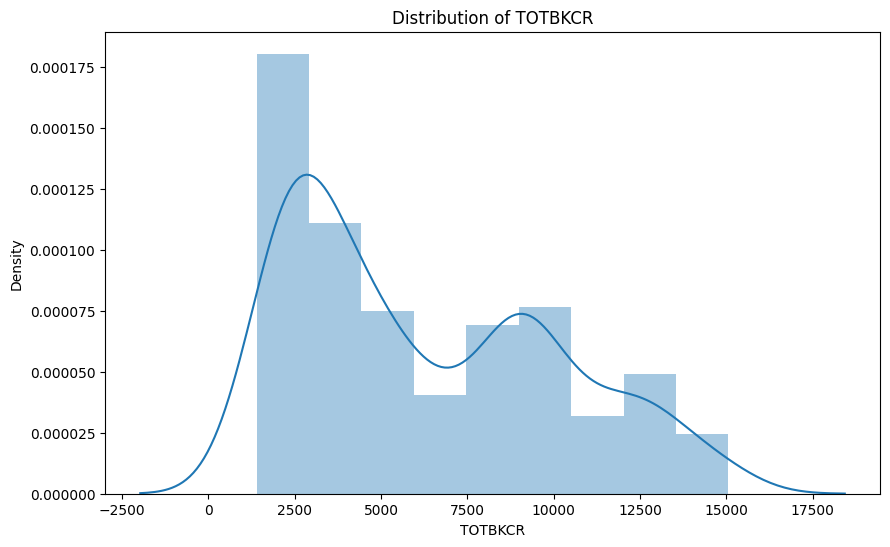

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


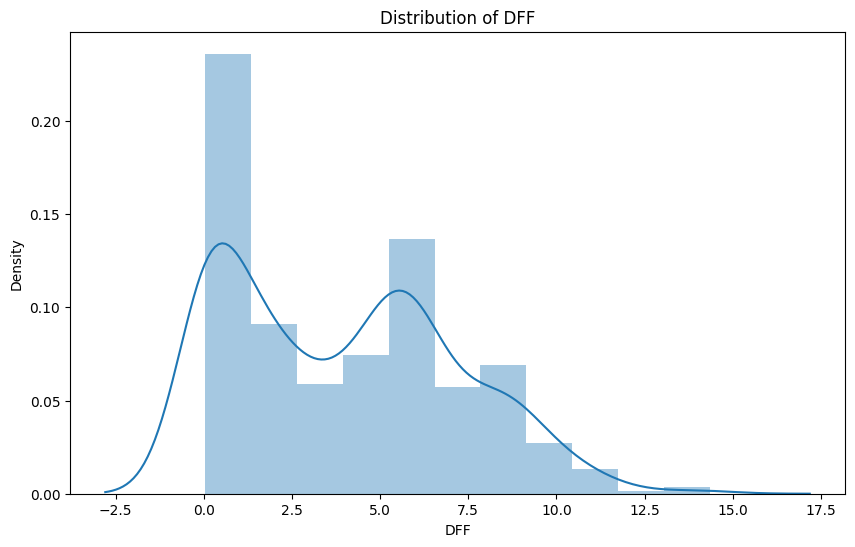

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


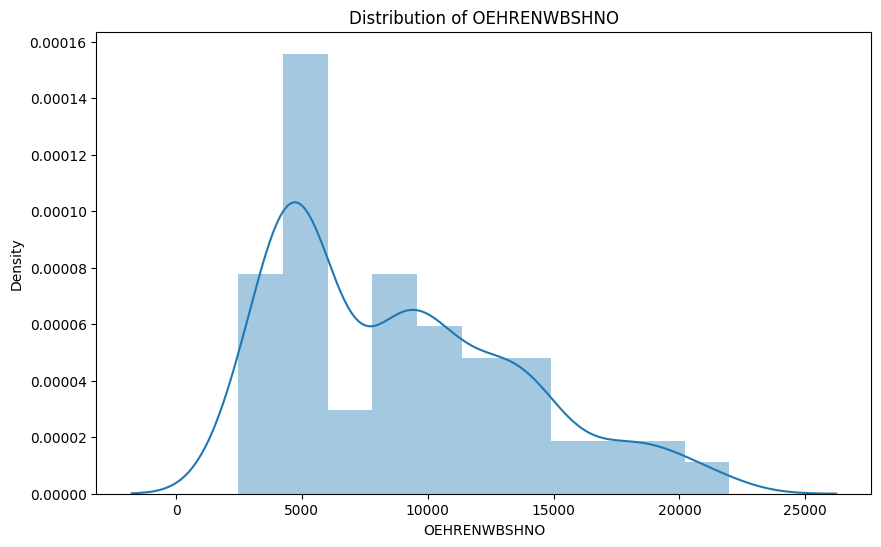

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


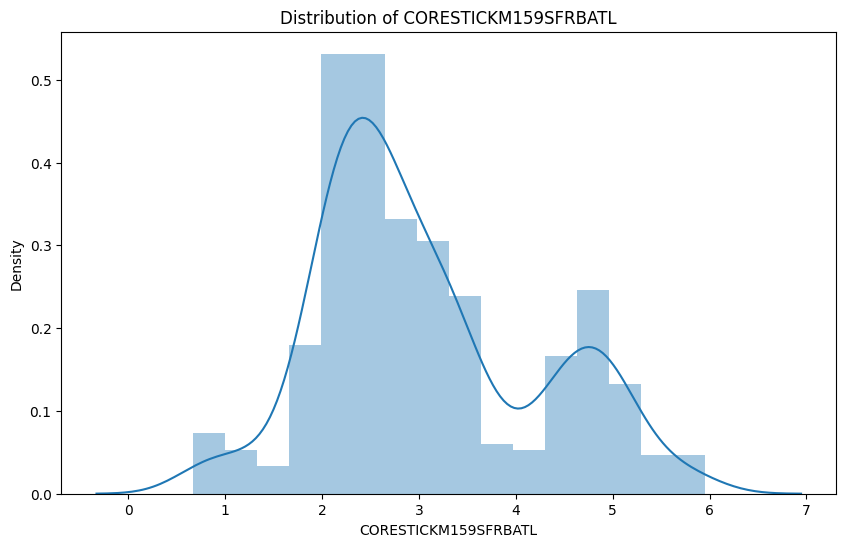

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


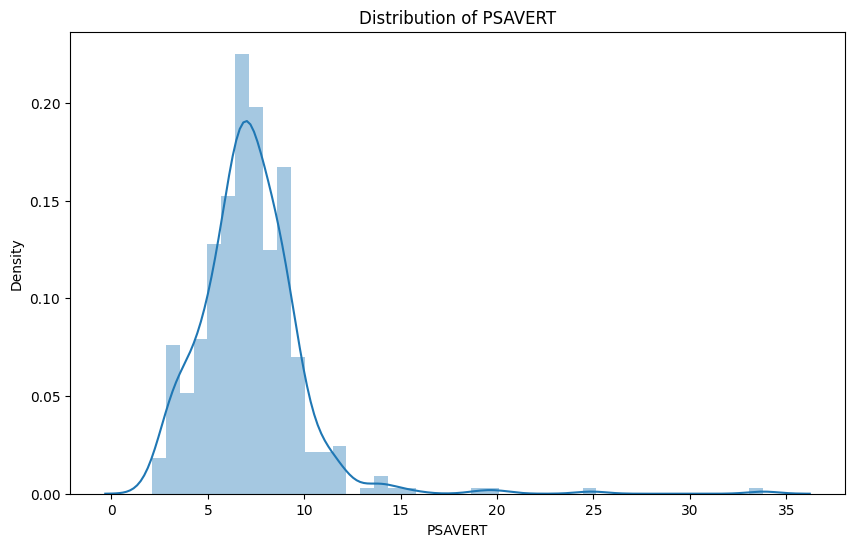

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


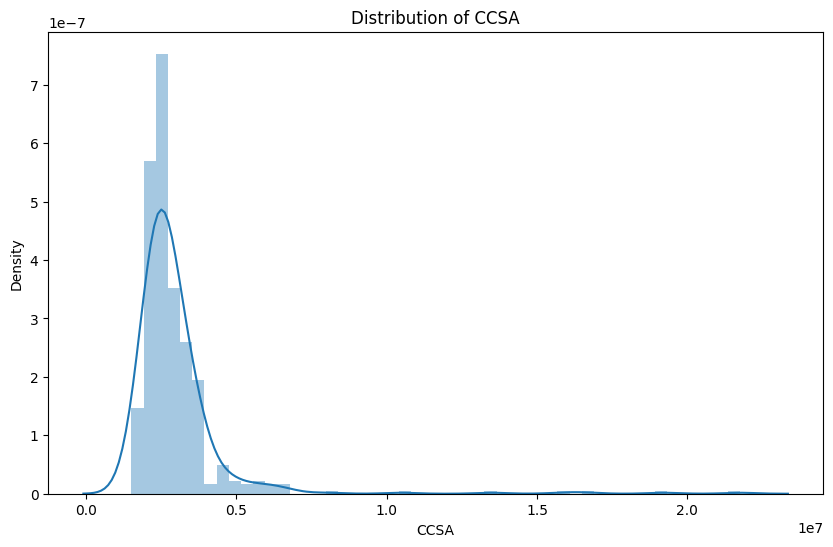

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


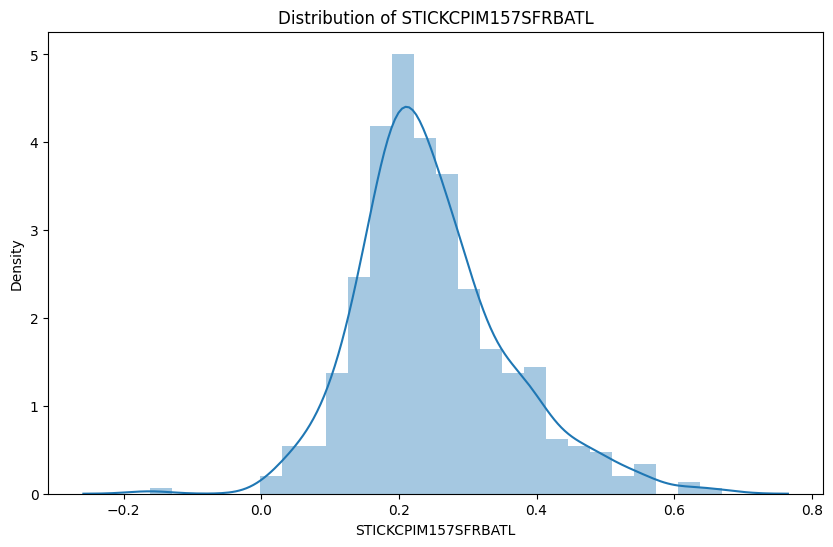

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


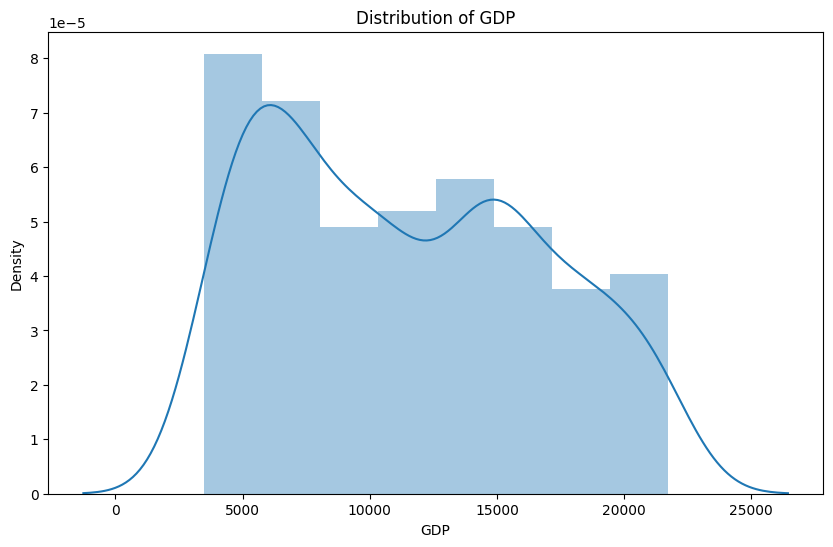

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


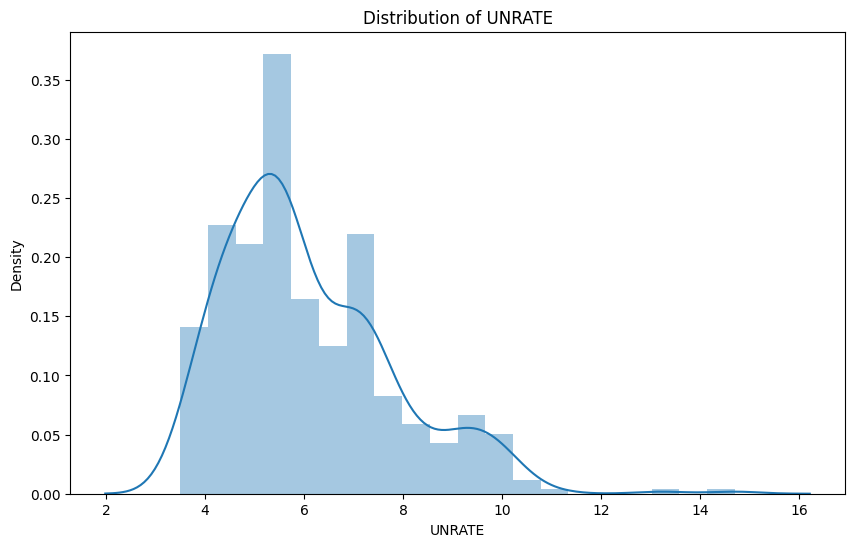

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


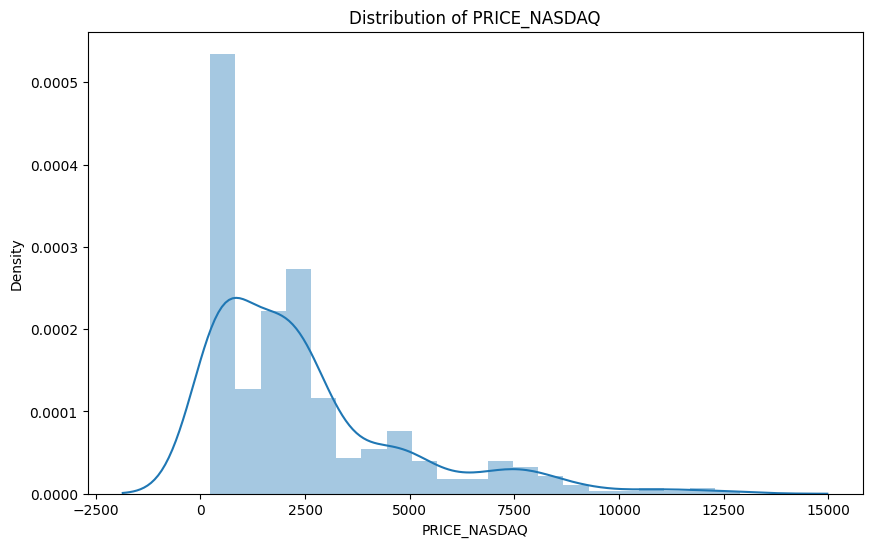

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


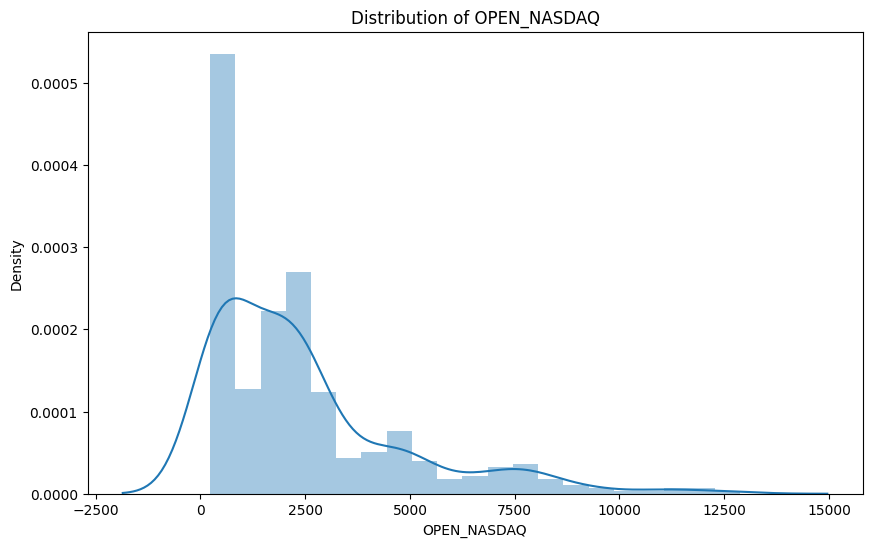

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


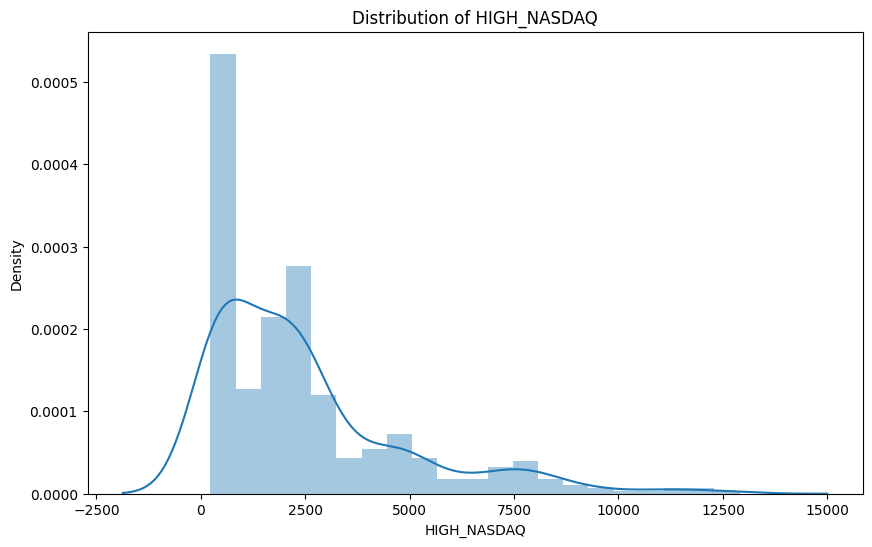

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


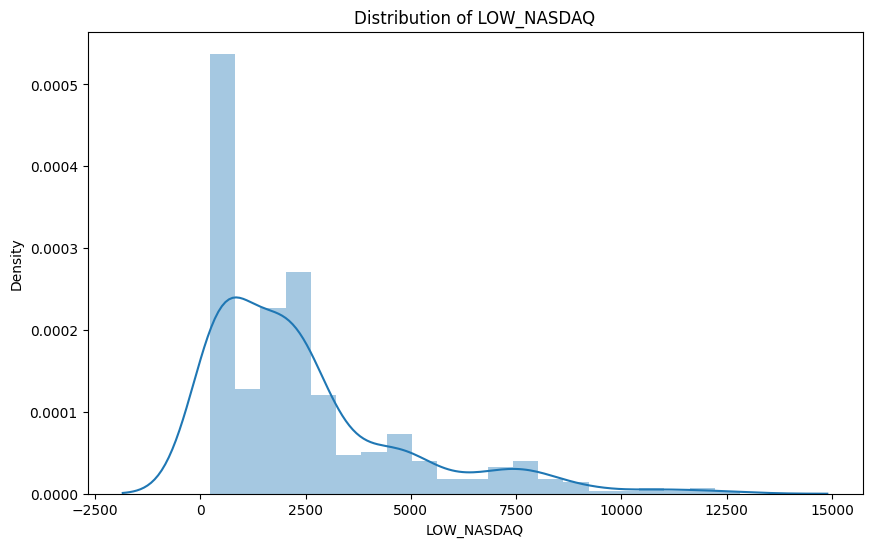

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


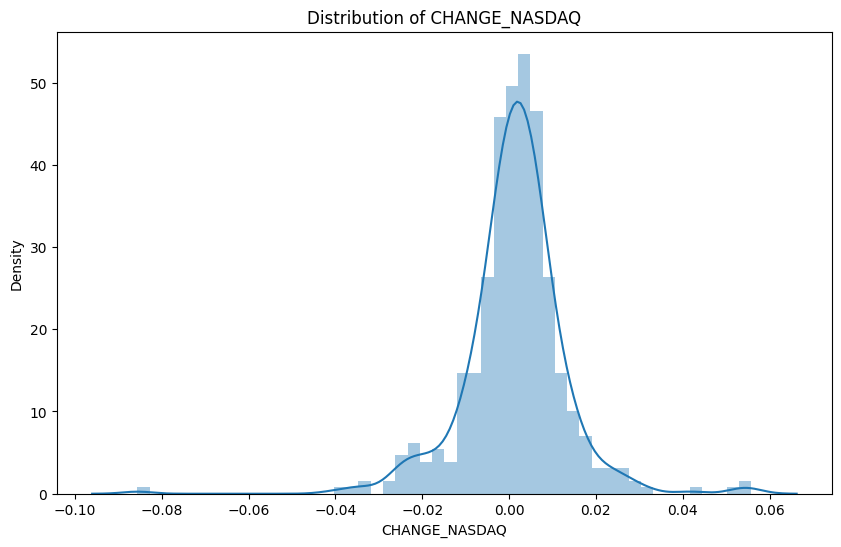

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


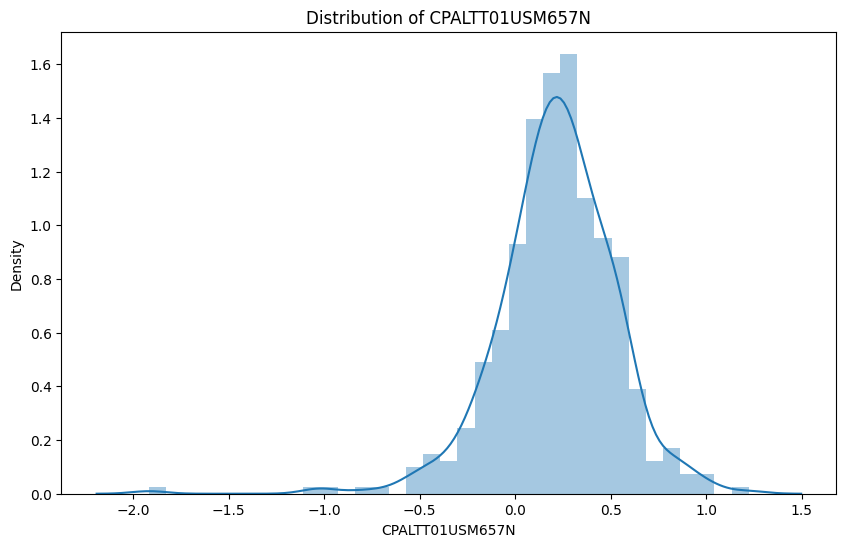

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


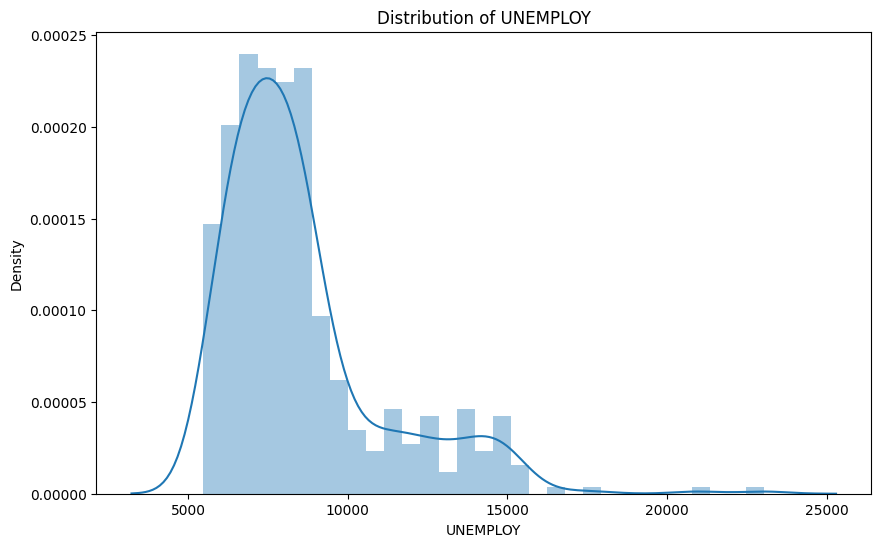

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


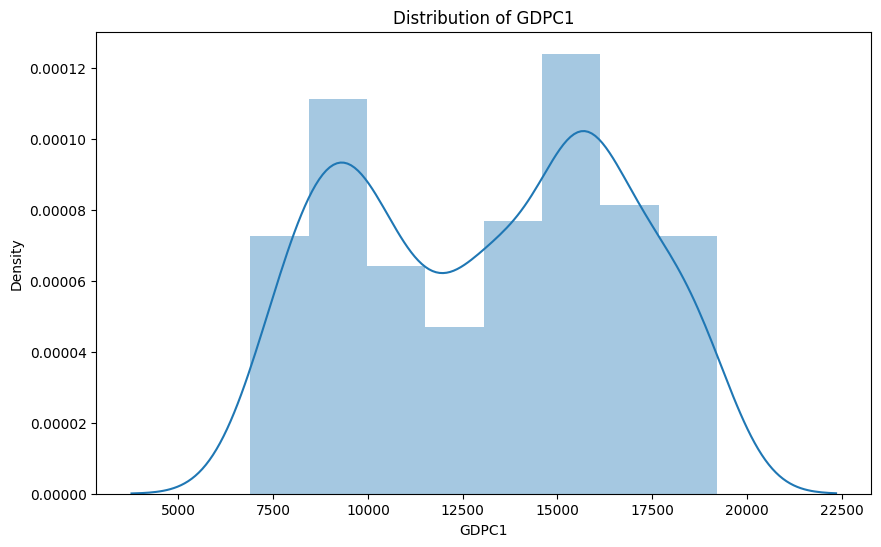

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


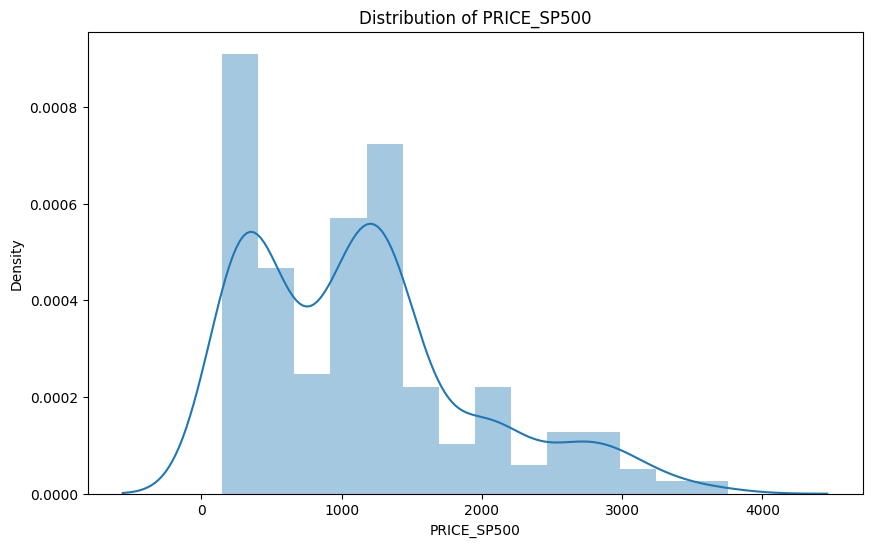

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


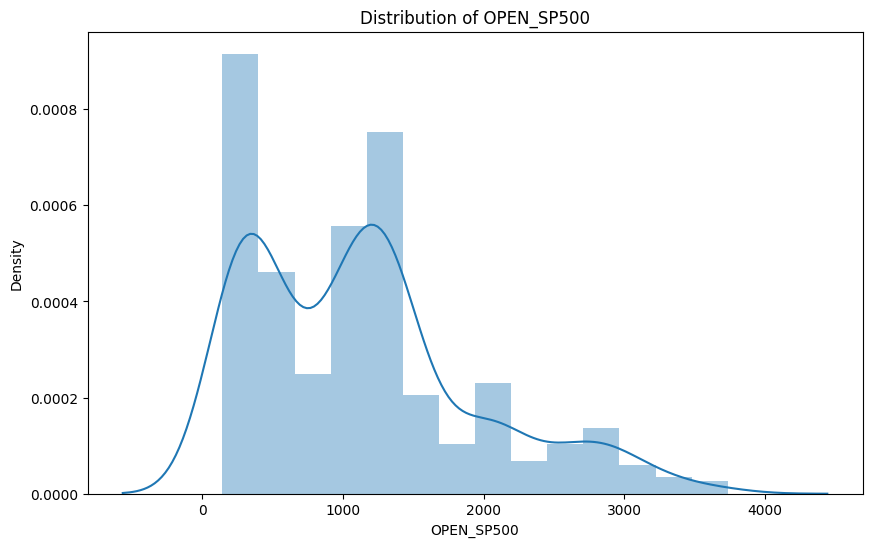

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


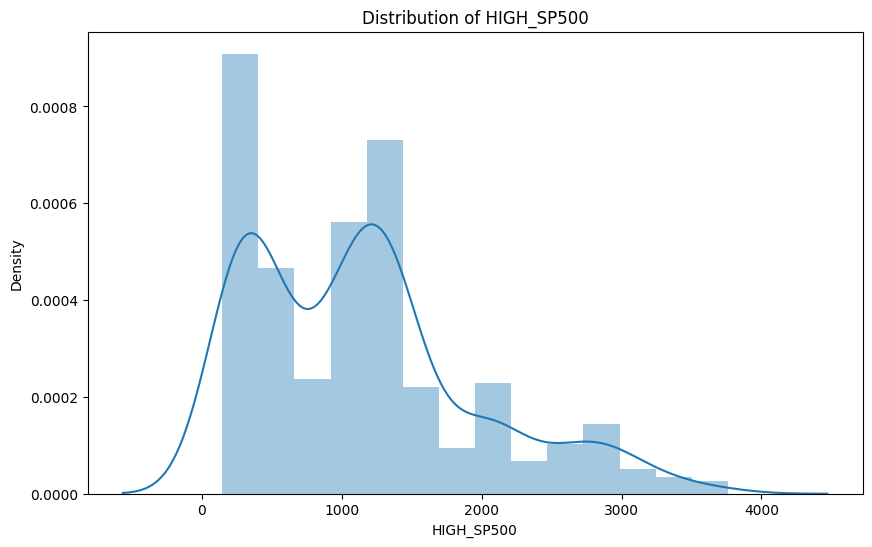

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


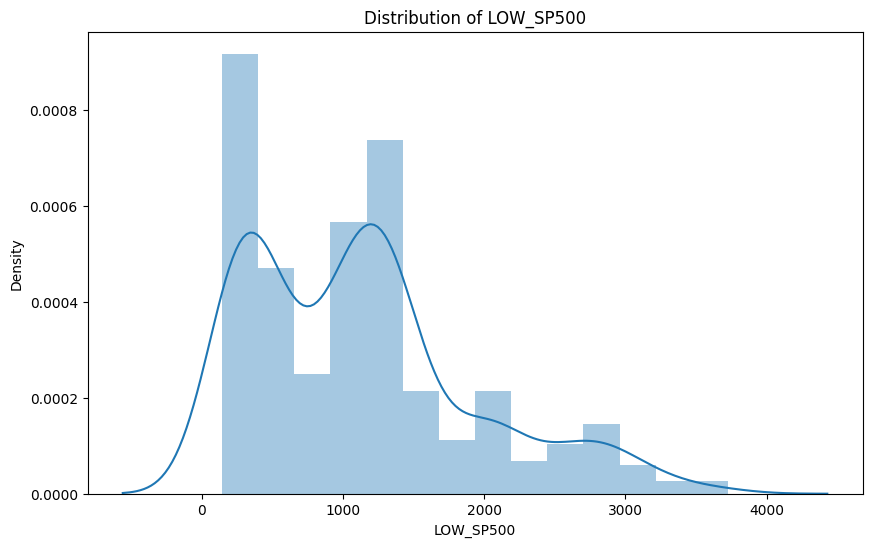

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


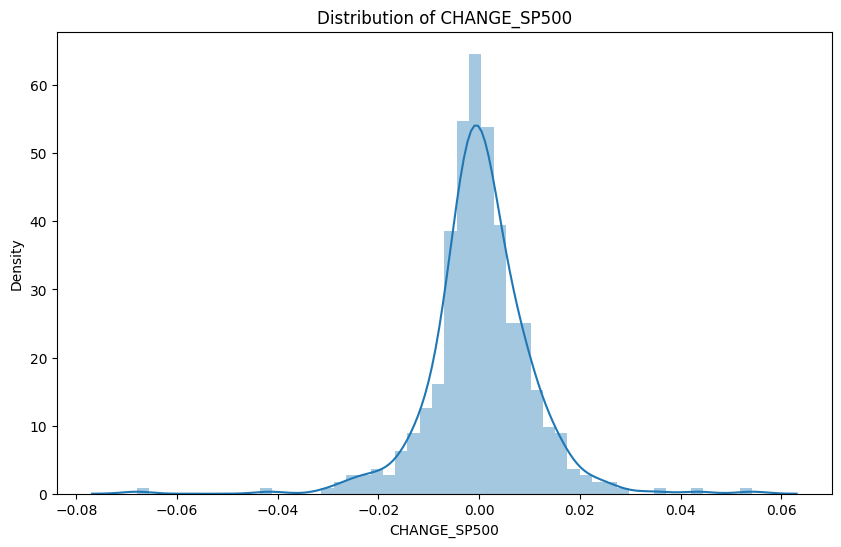

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


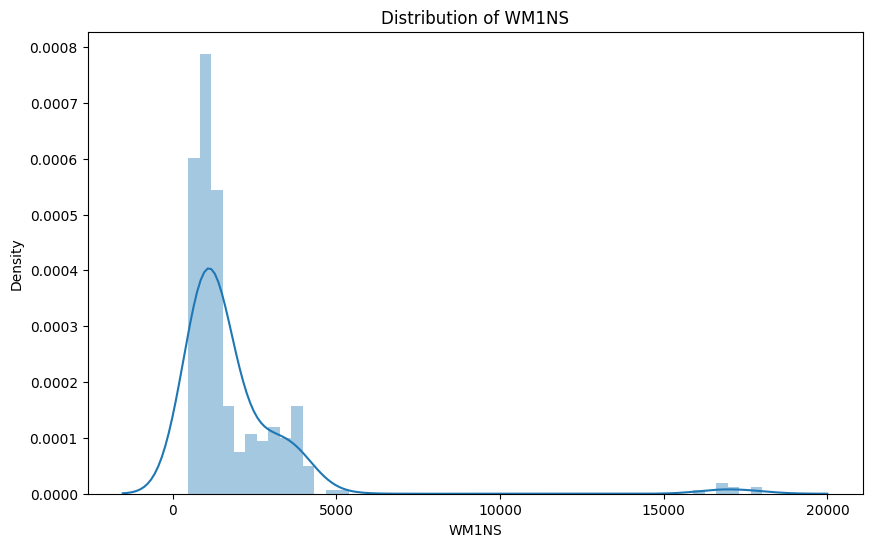

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


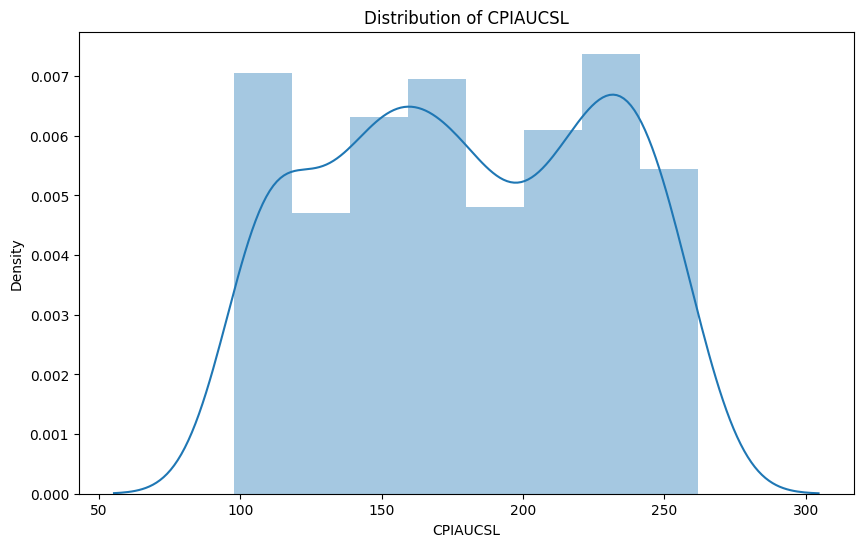

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


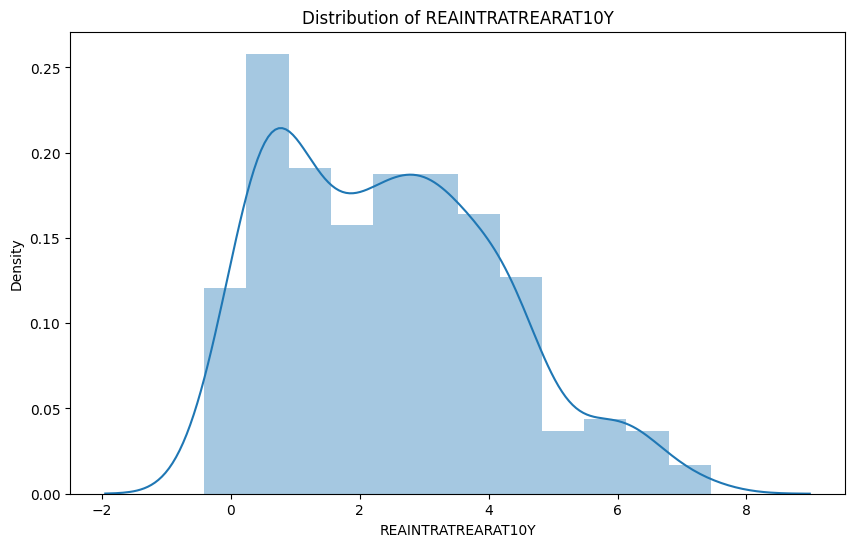

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


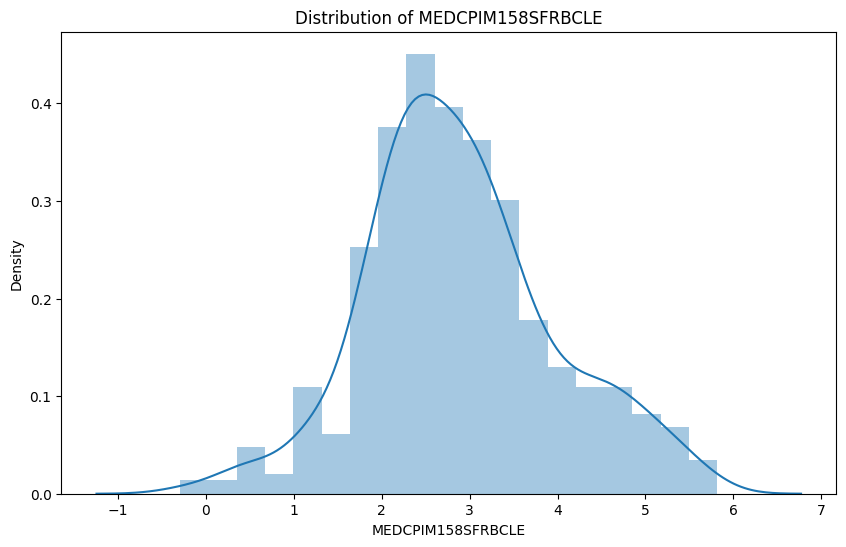

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


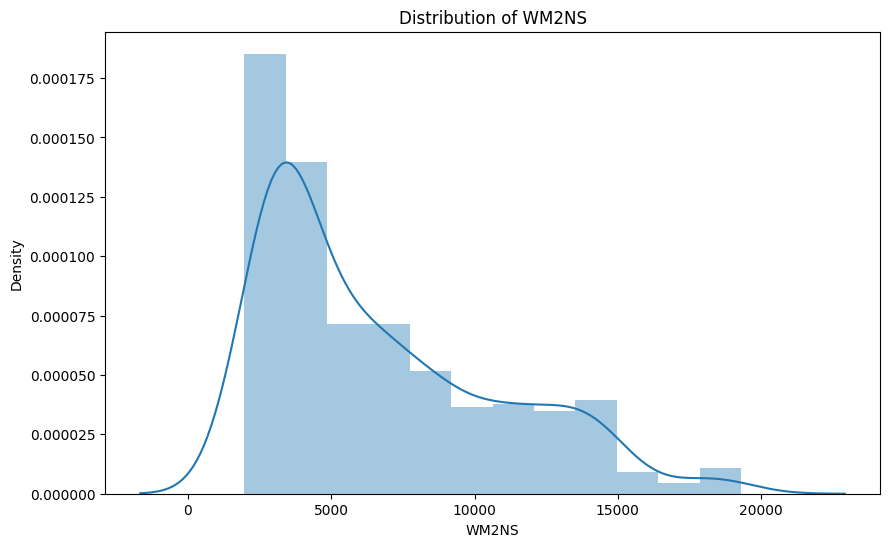

<ipython-input-19-c78e08e59b01>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model_df[column])


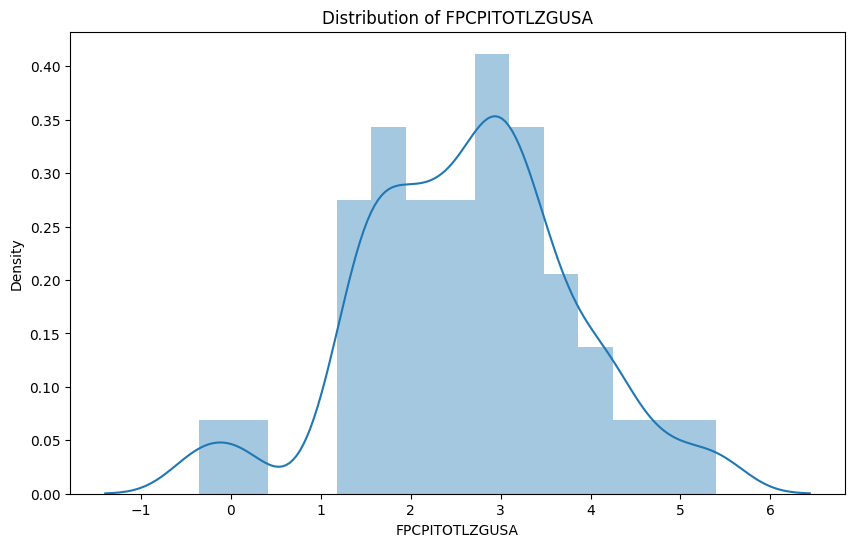

In [ ]:
#histograms
for column in model_df.columns.drop(['DATE','USREC']):
  plt.figure(figsize=(10, 6))
  sns.distplot(model_df[column])
  plt.title(f'Distribution of {column}')
  plt.show()

Now that we have explored (distributions, summary statistics, etc.) and cleaned (removed null values, fixed data types etc.) the dataset is ready for feature selection. First, let's explore when there have been recessions in the US according to the the actual labeled data so we can compare later.

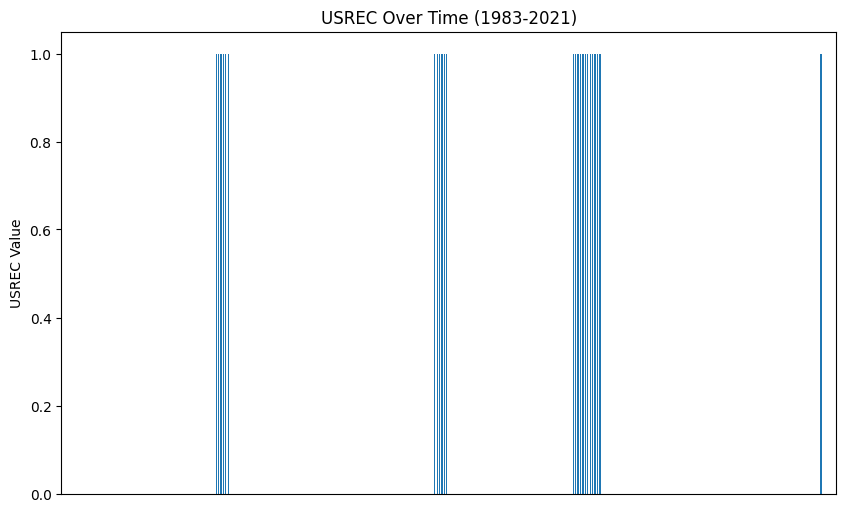

In [ ]:
#bar graph of recessions since 1983
plt.figure(figsize=(10, 6))
filtered_labels_df = recession_df[(recession_df['DATE'] >= '1983-01-01') & (recession_df['DATE'] <= '2021-01-01')]
filtered_labels_df.set_index('DATE')['USREC'].plot(kind='bar')
plt.title('USREC Over Time (1983-2021)')
plt.xlabel('')
plt.xticks([])
plt.ylabel('USREC Value')
plt.show()

# Feature Selection

We will identify which features are highly correlated so we can remove them and avoid redundancy.

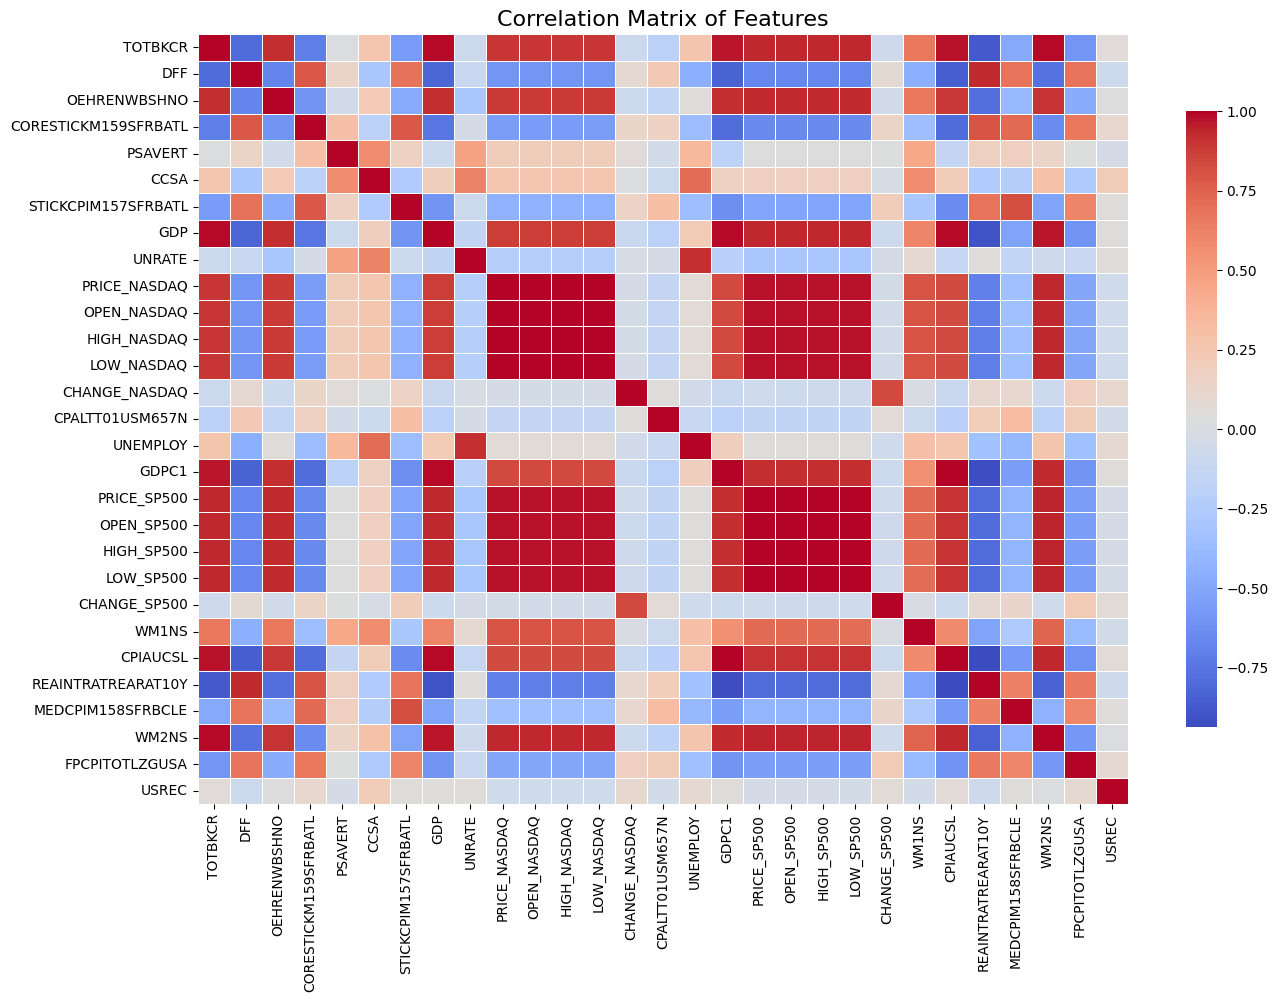

In [ ]:
heatmap_df_without_label = model_df.drop(columns=['DATE'])
correlation_matrix = heatmap_df_without_label.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',
            fmt=".2f", linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()

In [ ]:
print(correlation_matrix)

                       TOTBKCR       DFF  OEHRENWBSHNO  CORESTICKM159SFRBATL  \
TOTBKCR               1.000000 -0.794997      0.921459             -0.704451   
DFF                  -0.794997  1.000000     -0.678982              0.786097   
OEHRENWBSHNO          0.921459 -0.678982      1.000000             -0.601533   
CORESTICKM159SFRBATL -0.704451  0.786097     -0.601533              1.000000   
PSAVERT               0.020393  0.140461     -0.052578              0.296481   
CCSA                  0.263190 -0.288830      0.229162             -0.194244   
STICKCPIM157SFRBATL  -0.566723  0.682895     -0.479959              0.783881   
GDP                   0.990222 -0.822891      0.922261             -0.754296   
UNRATE               -0.087119 -0.108334     -0.289713             -0.036843   
PRICE_NASDAQ          0.895128 -0.591872      0.883145             -0.558827   
OPEN_NASDAQ           0.895639 -0.592523      0.883520             -0.559558   
HIGH_NASDAQ           0.895226 -0.592119

The S&P 500 and the NASDAQ are both stock indices meant to represent the market. Because of this, it is redundant to keep both so the S&P 500 will be prioritized. Additionally, it clear that the other S&P indicators (Open price, high, low, etc.) are highly correlated so they will not add any value. These features will all be removed.

In [ ]:
#remove highly correlated features
final_model_df = model_df.drop(columns=['PRICE_NASDAQ','OPEN_NASDAQ','HIGH_NASDAQ','LOW_NASDAQ','CHANGE_NASDAQ','OPEN_SP500','HIGH_SP500','LOW_SP500'])
final_model_df = final_model_df.set_index('DATE')
final_model_df

,TOTBKCR,DFF,OEHRENWBSHNO,CORESTICKM159SFRBATL,PSAVERT,CCSA,STICKCPIM157SFRBATL,GDP,UNRATE,CPALTT01USM657N,...,GDPC1,PRICE_SP500,CHANGE_SP500,WM1NS,CPIAUCSL,REAINTRATREARAT10Y,MEDCPIM158SFRBCLE,WM2NS,FPCPITOTLZGUSA,USREC
DATE,,,,,,,,,,,,,,,,,,,,,
1983-01-31,1396.8702,8.56,2474.362,4.695598,11.1,3890000.0,0.51170,3473.413,10.4,0.204918,...,6896.561,145.30,0.0055,467.5,97.900,5.543389,5.014653,1963.5,3.212435,0.0
1983-02-28,1400.5734,8.53,2474.362,4.627836,11.1,3876000.0,0.35447,3473.413,10.4,0.102249,...,6896.561,148.10,-0.0107,472.5,98.000,5.861705,4.952545,1989.0,3.212435,0.0
1983-03-31,1420.6188,10.81,2474.362,4.855813,10.6,3734000.0,0.23015,3473.413,10.3,0.000000,...,6896.561,153.00,-0.0026,476.3,98.100,5.573838,3.612261,2006.0,3.212435,0.0
1983-04-30,1430.1645,8.84,2494.423,4.456934,10.3,3722000.0,0.52142,3578.848,10.2,0.715015,...,7053.500,164.40,0.0092,492.2,98.800,5.700122,4.828054,2022.9,3.212435,0.0
1983-05-31,1441.6828,8.94,2494.423,3.549624,9.9,3457000.0,0.22823,3578.848,10.1,0.608519,...,7053.500,162.40,-0.0128,488.6,99.200,5.402394,3.767326,2031.0,3.212435,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,14920.2229,0.09,21175.542,2.288978,15.5,13501000.0,0.24904,21362.428,8.4,0.315321,...,18743.720,3500.31,-0.0022,16944.9,259.411,-0.407134,2.235723,18376.9,1.233584,0.0
2020-09-30,14944.5599,0.09,21175.542,2.077391,14.6,10481000.0,0.02761,21362.428,7.9,0.139275,...,18743.720,3363.00,0.0083,17098.6,260.029,-0.343337,1.133933,18488.3,1.233584,0.0
2020-10-31,14953.9365,0.09,21985.897,1.842159,14.0,6705000.0,0.08769,21704.706,6.9,0.041494,...,18924.262,3269.96,-0.0121,17279.3,260.286,-0.291738,1.838456,18640.9,1.233584,0.0


In [ ]:
# Confirm that all labels are either 0 or 1, and that valueCounts reflects exactly 456 elements. No one gets left behind!
# 0 = No Recession; 1 = Recession (as the imbalance suggests).
value_counts = final_model_df['USREC'].value_counts()
print(value_counts)

USREC
0.0    420
1.0     36
Name: count, dtype: int64


In [ ]:
# Just a quick sanity check:
final_model_df
final_model_df.shape #456,21

(456, 21)

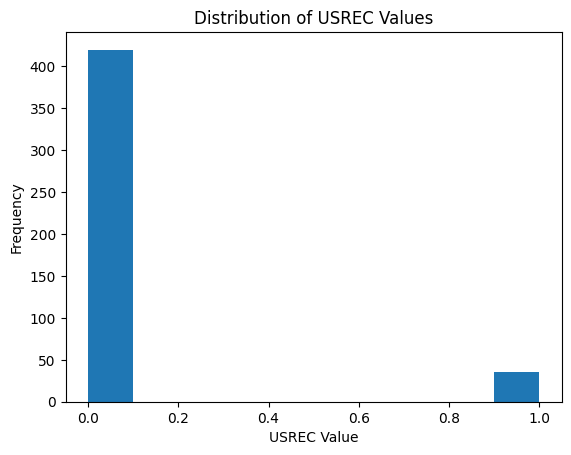

In [ ]:
#check distribution of label column

plt.hist(final_model_df['USREC'])
plt.xlabel('USREC Value')
plt.ylabel('Frequency')
plt.title('Distribution of USREC Values')
plt.show()

In [ ]:
#Prepare for models, create sequences, split into training and testing data

scaler = MinMaxScaler()

X = torch.tensor(final_model_df.drop('USREC', axis=1).values, dtype=torch.float32)
y = torch.tensor(final_model_df['USREC'].values, dtype=torch.float32)

X_scaled = scaler.fit_transform(X)
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)

train_size = int(0.8 * len(X_scaled))
train_X, test_X = X_scaled[:train_size], X_scaled[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

sequence_length = 12 ## Consider trying 6, 18 and 24. sequence_length will determine how much the model "sees" (or doesn't see).

def create_sequences(data_X, data_y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data_X) - seq_length):
        X_seq.append(data_X[i:i + seq_length])
        y_seq.append(data_y[i + seq_length])
    return torch.stack(X_seq), torch.tensor(y_seq)

train_X_seq, train_y_seq = create_sequences(train_X, train_y, sequence_length)
test_X_seq, test_y_seq = create_sequences(test_X, test_y, sequence_length)

train_y_seq = train_y_seq.unsqueeze(1)
test_y_seq = test_y_seq.unsqueeze(1)

dataset = TensorDataset(X, y)
train_dataset = TensorDataset(train_X_seq, train_y_seq)
test_dataset = TensorDataset(test_X_seq, test_y_seq)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(train_X_seq.shape)
print(train_y_seq.shape)
print(test_y_seq.shape)

torch.Size([352, 12, 20])
torch.Size([352, 1])
torch.Size([80, 1])


# Predictive Modeling

RNN Model

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output[:, -1, :])  # Only take the output from the last time step
        # output = torch.tanh(output)  # Apply tanh activation
        # output = torch.relu(output)  # Apply ReLU activation
        return output

# Hyperparameters
input_size = train_X_seq.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1  # Binary classification
num_epochs = 100



# Create the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

Epoch [1/100], Loss: 0.5678
Epoch [2/100], Loss: 0.3227
Epoch [3/100], Loss: 0.3224
Epoch [4/100], Loss: 0.3192
Epoch [5/100], Loss: 0.3177
Epoch [6/100], Loss: 0.3173
Epoch [7/100], Loss: 0.3175
Epoch [8/100], Loss: 0.3173
Epoch [9/100], Loss: 0.3191
Epoch [10/100], Loss: 0.3171
Epoch [11/100], Loss: 0.3183
Epoch [12/100], Loss: 0.3155
Epoch [13/100], Loss: 0.3168
Epoch [14/100], Loss: 0.3132
Epoch [15/100], Loss: 0.3070
Epoch [16/100], Loss: 0.2953
Epoch [17/100], Loss: 0.2758
Epoch [18/100], Loss: 0.2263
Epoch [19/100], Loss: 0.3637
Epoch [20/100], Loss: 0.3402
Epoch [21/100], Loss: 0.3213
Epoch [22/100], Loss: 0.3193
Epoch [23/100], Loss: 0.3170
Epoch [24/100], Loss: 0.3172
Epoch [25/100], Loss: 0.3165
Epoch [26/100], Loss: 0.3163
Epoch [27/100], Loss: 0.3169
Epoch [28/100], Loss: 0.3179
Epoch [29/100], Loss: 0.3190
Epoch [30/100], Loss: 0.3185
Epoch [31/100], Loss: 0.3131
Epoch [32/100], Loss: 0.3146
Epoch [33/100], Loss: 0.3129
Epoch [34/100], Loss: 0.3074
Epoch [35/100], Loss: 0

RNN Model Evaluation

In [ ]:
# Model evaluation
model.eval()
threshold = 0.3
test_predictions = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)  # Apply sigmoid activation
        predicted_labels = (probabilities > threshold).float()  # Threshold at 0.5
        test_predictions.extend(predicted_labels.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())

# Convert to numpy arrays for sklearn metrics
test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
# roc_auc = roc_auc_score(test_labels, test_predictions)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"ROC-AUC: {roc_auc:.4f}")


Accuracy: 0.4000
Precision: 0.0400
Recall: 1.0000
F1 Score: 0.0769


The high imbalance of the data (92% are 0 - no recession and 8% are 1 - recession) is likely affecting the accuracy of the model. We will see if this impacts the LSTM model as well and then attempt the model with class weighting.

**NEXT: the Long Short-Term Memory (LSTM) Model.**

In [ ]:
## LSTM MODEL: Begin by initializing the class. LSTM as we know is a variant of Neural Network.

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Dense (i.e. fully connected) layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the last time step's output
        out = self.fc(out[:, -1, :])
        return out
print("LSTM class ready to roll.")

LSTM class ready to roll.


LSTM Model: TRAINING DAY

In [ ]:
## Start by setting our hyperparams:
input_size = train_X_seq.shape[2]  # How many features?
hidden_size = 64 # How many hidden units?
num_layers = 3 # How many LSTM layers?
output_size = 1 # Binary classification (predicting USREC, either 0 or 1.)
num_epochs = 100
batch_size = 32
learning_rate = 0.001

## Initialize our model.
## ⚠️ ⚠️ ⚠️ We will use the variable `lsModel` for LSTM.
lsModel = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
optimizer = torch.optim.Adam(lsModel.parameters(), lr=learning_rate)

# Leverage GPU if we can - otherwise, CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lsModel.to(device)

## Training day for LSTM:

for epoch in range(num_epochs):
    lsModel.train()
    epoch_loss = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # This conducts the forward pass
        outputs = lsModel(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward-pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

print("\nLSTM model training complete.\n")

Epoch [1/100], Loss: 0.6509
Epoch [2/100], Loss: 0.3678
Epoch [3/100], Loss: 0.3267
Epoch [4/100], Loss: 0.3228
Epoch [5/100], Loss: 0.3189
Epoch [6/100], Loss: 0.3173
Epoch [7/100], Loss: 0.3204
Epoch [8/100], Loss: 0.3192
Epoch [9/100], Loss: 0.3179
Epoch [10/100], Loss: 0.3179
Epoch [11/100], Loss: 0.3195
Epoch [12/100], Loss: 0.3173
Epoch [13/100], Loss: 0.3174
Epoch [14/100], Loss: 0.3163
Epoch [15/100], Loss: 0.3145
Epoch [16/100], Loss: 0.3110
Epoch [17/100], Loss: 0.2969
Epoch [18/100], Loss: 0.2765
Epoch [19/100], Loss: 0.2447
Epoch [20/100], Loss: 0.2505
Epoch [21/100], Loss: 0.3229
Epoch [22/100], Loss: 0.3397
Epoch [23/100], Loss: 0.3229
Epoch [24/100], Loss: 0.3179
Epoch [25/100], Loss: 0.3189
Epoch [26/100], Loss: 0.3170
Epoch [27/100], Loss: 0.3174
Epoch [28/100], Loss: 0.3140
Epoch [29/100], Loss: 0.3075
Epoch [30/100], Loss: 0.2875
Epoch [31/100], Loss: 0.2467
Epoch [32/100], Loss: 0.2240
Epoch [33/100], Loss: 0.2371
Epoch [34/100], Loss: 0.2577
Epoch [35/100], Loss: 0

**LSTM Model Evaluation**

In [ ]:
######## EVALUATE AND PRINT RESULTS FOR LSTM ###############
lsModel.eval()
test_loss = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = lsModel(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect true labels and predicted labels
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid for probabilities
        predicted_labels = (probabilities > 0.5).astype(int)  # Set threshold at 0.5 for binary predictions
        all_predictions.extend(predicted_labels.flatten())    # Append predictions
        all_labels.extend(labels.cpu().numpy())              # Append true labels

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Compute apr-f1:
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, zero_division=0)
recall = recall_score(all_labels, all_predictions, zero_division=0)
f1 = f1_score(all_labels, all_predictions, zero_division=0)

print(f'LSTM EVALUATION RESULTS:\n\nTest Loss: {test_loss / len(test_loader):.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

## Reminder: "recall = 1" means the model correctly found all instances of the TARGET class.

LSTM EVALUATION RESULTS:

Test Loss: 0.5265
Accuracy: 0.4125
Precision: 0.0408
Recall: 1.0000
F1-Score: 0.0784


# Predictive Modeling - with class weighting

Updated model preparation

Updated RNN Model

Updated RNN Model Evaluation

**Updated LSTM Model (Class Weighting): Training and Eval**

In [ ]:
## LSTM again, but this time we implement CLASS WEIGHTING.

## Start by setting our hyperparams, similar to the previous LSTM runthrough:

input_size = train_X_seq.shape[2]  # How many features?
hidden_size = 64  # How many hidden units?
num_layers = 3  # How many LSTM layers?
output_size = 1  # Binary classification (predicting USREC, either 0 or 1.)
num_epochs = 200
batch_size = 16 # tip: SMALLER batch sizes will the the model see the 1s (recession) more frequently.
learning_rate = 0.001 # Consider going lower than 0.001, for more careful, cautious convergence.

## Initialize our LSTM model.
## ⚠️ ⚠️ ⚠️ Variable `lstmCWmodel` is used in this section.

## class LSTMModel(nn.Module):
## No need to redefine! we are using the same one.

lstmCWmodel = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Leverage GPU if we can - otherwise, CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstmCWmodel.to(device)

# Class weighting for SEVERE imbalance. We have 36 1s (Recession) and 420 0s (No Recessoin).
total_samples = 456  # Total samples (36 positives, 420 negatives)
pos_weight = total_samples / 36  # Weight for class 1
neg_weight = total_samples / 420  # Weight for class 0

# WEIGHTED loss function. *This* is where the Class Weighting is applied.
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
optimizer = optim.Adam(lstmCWmodel.parameters(), lr=learning_rate)
######################### TRAINING PHASE #########################################################
## Training loop
for epoch in range(num_epochs):
    lstmCWmodel.train()
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = lstmCWmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

############################ EVALUATION PHASE #########################################################################
lstmCWmodel.eval()
test_loss = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = lstmCWmodel(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect predictions and labels
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
        predicted_labels = (probabilities > 0.5).astype(int)  # Threshold at 0.5
        all_predictions.extend(predicted_labels.flatten())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, zero_division=0)
recall = recall_score(all_labels, all_predictions, zero_division=0)
f1 = f1_score(all_labels, all_predictions, zero_division=0)

# Final results
print("\nLSTM Evaluation Results, with CLASS WEIGHTING in play:\n\n")
print(f'Test Loss: {test_loss / len(test_loader):.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Epoch [1/200], Loss: 1.4631
Epoch [2/200], Loss: 1.4617
Epoch [3/200], Loss: 1.4121
Epoch [4/200], Loss: 1.3650
Epoch [5/200], Loss: 1.1617
Epoch [6/200], Loss: 0.8550
Epoch [7/200], Loss: 0.7850
Epoch [8/200], Loss: 0.6004
Epoch [9/200], Loss: 1.0341
Epoch [10/200], Loss: 1.4992
Epoch [11/200], Loss: 1.3852
Epoch [12/200], Loss: 1.3789
Epoch [13/200], Loss: 1.3720
Epoch [14/200], Loss: 1.3559
Epoch [15/200], Loss: 1.2939
Epoch [16/200], Loss: 1.0978
Epoch [17/200], Loss: 0.7759
Epoch [18/200], Loss: 0.6196
Epoch [19/200], Loss: 0.5843
Epoch [20/200], Loss: 0.5898
Epoch [21/200], Loss: 0.4892
Epoch [22/200], Loss: 0.4562
Epoch [23/200], Loss: 0.4179
Epoch [24/200], Loss: 0.5499
Epoch [25/200], Loss: 0.4621
Epoch [26/200], Loss: 0.5518
Epoch [27/200], Loss: 0.4128
Epoch [28/200], Loss: 0.4021
Epoch [29/200], Loss: 0.3986
Epoch [30/200], Loss: 0.3979
Epoch [31/200], Loss: 0.4061
Epoch [32/200], Loss: 0.4791
Epoch [33/200], Loss: 0.5121
Epoch [34/200], Loss: 0.9685
Epoch [35/200], Loss: 0

***LSTM-SMOTE attempt:***
(spoiler alert - not very good at all)

In [ ]:


# Convert tensors to numpy arrays (needed for SMOTE)
train_X_np = train_X_seq.numpy()  # Convert your input data (train_X_seq) to a numpy array
train_y_np = train_y_seq.numpy()  # Convert your labels (train_y_seq) to a numpy array

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
train_X_resampled, train_y_resampled = smote.fit_resample(train_X_np.reshape(train_X_np.shape[0], -1), train_y_np)

# Convert back to PyTorch tensors after SMOTE
train_X_resampled = torch.tensor(train_X_resampled.reshape(train_X_resampled.shape[0], sequence_length, -1), dtype=torch.float32)
train_y_resampled = torch.tensor(train_y_resampled, dtype=torch.float32)

# Create the DataLaoder
train_dataset_resampled = TensorDataset(train_X_resampled, train_y_resampled)
train_loader_resampled = DataLoader(train_dataset_resampled, batch_size=batch_size, shuffle=True)

lstmSMOTE = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Leverage GPU if we can - otherwise, CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstmSMOTE.to(device)

### TRAINING PHASE ###
# Use train_loader_resampled for training, instead of the original train_loader we used before.
for epoch in range(num_epochs):
    lstmSMOTE.train()
    epoch_loss = 0

    for inputs, labels in train_loader_resampled:
        inputs, labels = inputs.to(device), labels.to(device)

        labels = labels.unsqueeze(1)  # Convert shape from [batch_size] to [batch_size, 1] so that loss = criterion(outputs, labels) receives the correct shape.

        optimizer.zero_grad()
        outputs = lstmSMOTE(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader_resampled):.4f}')

######### EVALUATION PHASE #########
# Put the model in evaluation mode
lstmSMOTE.eval()

# Initialize variables to store results
test_loss = 0
all_labels = []
all_predictions = []

# Evaluate the model on the test data
with torch.no_grad():  # No need to track gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = lstmSMOTE(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert logits to probabilities and make predictions
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
        predicted_labels = (probabilities > 0.5).astype(int)  # Threshold at 0.5 to classify as 0 or 1

        # Store predictions and true labels for metrics
        all_predictions.extend(predicted_labels.flatten())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)
# Precision
precision = precision_score(all_labels, all_predictions)
# Recall
recall = recall_score(all_labels, all_predictions)
# F1 Score
f1 = f1_score(all_labels, all_predictions)

# Print results
print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Epoch [1/200], Loss: 5.0044
Epoch [2/200], Loss: 5.0135
Epoch [3/200], Loss: 5.0135
Epoch [4/200], Loss: 5.0089
Epoch [5/200], Loss: 5.0135
Epoch [6/200], Loss: 5.0044
Epoch [7/200], Loss: 5.0180
Epoch [8/200], Loss: 5.0135
Epoch [9/200], Loss: 5.0089
Epoch [10/200], Loss: 5.0135
Epoch [11/200], Loss: 5.0135
Epoch [12/200], Loss: 5.0044
Epoch [13/200], Loss: 5.0089
Epoch [14/200], Loss: 5.0044
Epoch [15/200], Loss: 5.0089
Epoch [16/200], Loss: 5.0135
Epoch [17/200], Loss: 5.0135
Epoch [18/200], Loss: 5.0044
Epoch [19/200], Loss: 5.0089
Epoch [20/200], Loss: 5.0089
Epoch [21/200], Loss: 4.9999
Epoch [22/200], Loss: 4.9999
Epoch [23/200], Loss: 5.0089
Epoch [24/200], Loss: 5.0135
Epoch [25/200], Loss: 4.9908
Epoch [26/200], Loss: 5.0044
Epoch [27/200], Loss: 5.0044
Epoch [28/200], Loss: 5.0180
Epoch [29/200], Loss: 4.9999
Epoch [30/200], Loss: 5.0180
Epoch [31/200], Loss: 5.0135
Epoch [32/200], Loss: 5.0135
Epoch [33/200], Loss: 5.0044
Epoch [34/200], Loss: 5.0089
Epoch [35/200], Loss: 5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# A new approach

To attempt getting a higher accuracy, we are going to make some updates to the data we're running through the model. Due to the sparsity of recessions, will expand the dataset back a few more years. We will need to remove some of the indicators that do not have data that far back in our dataset, however we will enhance the dataset now through feature engineering. We will add new features such as rolling averages and inverted yield curve (10 yr treasury yield minus 2 year treasury yield).

In [ ]:
files.upload()

# ⚠️ 10-year treasury yield: ensure DGS10.csv is ready to go!
tenyrtydf = pd.read_csv("DGS10.csv")

Saving DGS10.csv to DGS10 (1).csv


In [ ]:
files.upload()

#⚠️ 2-year treasury yield: ensure DGS2.csv is also ready to go.
twoyrtydf = pd.read_csv("DGS2.csv")

Saving DGS2.csv to DGS2 (1).csv


The inverted yield curve is an unusual phenonmenon that happens when short term interest rates are higher than long term interest rates, often an indicator of economic downturn. Comparing the 10 year treasury yield against the 2 year treasury yield is a common way of determining an inverted yield curve.

In [ ]:
#inverted yield curve df
twoyrtydf["observation_date"] = pd.to_datetime(twoyrtydf["observation_date"])
tenyrtydf["observation_date"] = pd.to_datetime(tenyrtydf["observation_date"])

twoyrtydf = twoyrtydf.set_index("observation_date").resample("M").last().reset_index()
tenyrtydf = tenyrtydf.set_index("observation_date").resample("M").last().reset_index()

combined_yieldcurve_df = pd.merge(twoyrtydf, tenyrtydf, on="observation_date", how="outer")

combined_yieldcurve_df = combined_yieldcurve_df[
    (combined_yieldcurve_df["observation_date"] >= "1976-06-01") &
    (combined_yieldcurve_df["observation_date"] <= "2021-01-01")
]
combined_yieldcurve_df = combined_yieldcurve_df.sort_values(by="observation_date").reset_index(drop=True)

print(combined_yieldcurve_df)

    observation_date  DGS2  DGS10
0         1976-06-30  7.02   7.86
1         1976-07-31  6.74   7.86
2         1976-08-31  6.50   7.66
3         1976-09-30  6.33   7.55
4         1976-10-31  6.03   7.42
..               ...   ...    ...
530       2020-08-31  0.14   0.72
531       2020-09-30  0.13   0.69
532       2020-10-31  0.14   0.88
533       2020-11-30  0.16   0.84
534       2020-12-31  0.13   0.93

[535 rows x 3 columns]


<ipython-input-37-401f32e09ac7>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  twoyrtydf = twoyrtydf.set_index("observation_date").resample("M").last().reset_index()
<ipython-input-37-401f32e09ac7>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tenyrtydf = tenyrtydf.set_index("observation_date").resample("M").last().reset_index()


Check for any nulls values in inverted yield curve df

In [ ]:
if combined_yieldcurve_df.isnull().any().any():
    print("Warning: The DataFrame contains null values.")
else:
    print("No null values found in the DataFrame.")

No null values found in the DataFrame.


Enhance the dataframe with is_inverted_yieldcurve binary column

In [ ]:
combined_yieldcurve_df["is_inverted"] = (
    combined_yieldcurve_df["DGS2"] > combined_yieldcurve_df["DGS10"]
).astype(int)

final_yieldcurve_df = combined_yieldcurve_df.drop(columns=["DGS2", "DGS10"])

final_yieldcurve_df

,observation_date,is_inverted
0,1976-06-30,0
1,1976-07-31,0
2,1976-08-31,0
3,1976-09-30,0
4,1976-10-31,0
...,...,...
530,2020-08-31,0
531,2020-09-30,0
532,2020-10-31,0
533,2020-11-30,0


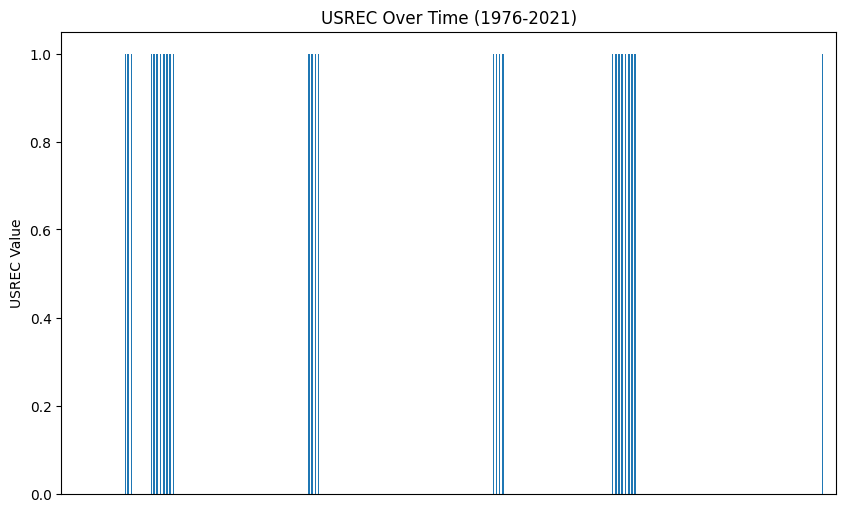

In [ ]:
#bar graph of recessions since 1976
plt.figure(figsize=(10, 6))
filtered_76_df = recession_df[(recession_df['DATE'] >= '1976-06-01') & (recession_df['DATE'] <= '2021-01-01')]
filtered_76_df.set_index('DATE')['USREC'].plot(kind='bar')
plt.title('USREC Over Time (1976-2021)')
plt.xlabel('')
plt.xticks([])
plt.ylabel('USREC Value')
plt.show()

By extending back to 1976, we are able to capture 2 more recessions (6 total) as opposed to only 4 total recessions when our data only went back to 1983.

In [ ]:
print(filtered_76_df.columns.tolist())

['DATE', 'USREC', 'TOTBKCR', 'DFF', 'OEHRENWBSHNO', 'CORESTICKM159SFRBATL', 'PSAVERT', 'CCSA', 'STICKCPIM157SFRBATL', 'GDP', 'CCLACBW027SBOG', 'UNRATE', 'PRICE_x', 'OPEN_x', 'HIGH_x', 'LOW_x', 'VOL._x', 'CHANGE %_x', 'DRCCLACBS', 'COMREPUSQ159N', 'CPALTT01USM657N', 'RHEACBW027SBOG_x', 'UNEMPLOY', 'GDPC1', 'PRICE_y', 'OPEN_y', 'HIGH_y', 'LOW_y', 'VOL._y', 'CHANGE %_y', 'WM1NS', 'CPIAUCSL', 'REAINTRATREARAT10Y', 'MEDCPIM158SFRBCLE', 'WM2NS', 'FPCPITOTLZGUSA', 'RHEACBW027SBOG_y', 'U6RATE']


In [ ]:
columns_with_nans = filtered_76_df.isna().any()
columns_with_nans = columns_with_nans[columns_with_nans].index.tolist()

print("Columns with NaN values:", columns_with_nans)

# Drop these columns from filtered_76_df
filtered_76_df_cleaned = filtered_76_df.drop(columns=columns_with_nans)

# Check if there are any NaN values left in the cleaned dataframe
# nan_counts = filtered_76_df_cleaned.isna().sum()

# Print the count of NaN values for each column
# print("NaN counts per column after removing columns with NaNs:")
# print(nan_counts)

Columns with NaN values: ['CCLACBW027SBOG', 'PRICE_x', 'OPEN_x', 'HIGH_x', 'LOW_x', 'VOL._x', 'CHANGE %_x', 'DRCCLACBS', 'COMREPUSQ159N', 'RHEACBW027SBOG_x', 'PRICE_y', 'OPEN_y', 'HIGH_y', 'LOW_y', 'VOL._y', 'CHANGE %_y', 'REAINTRATREARAT10Y', 'MEDCPIM158SFRBCLE', 'WM2NS', 'RHEACBW027SBOG_y', 'U6RATE']


In [ ]:
nan_counts = filtered_76_df_cleaned.isna().sum()

# Print the count of NaN values for each column
print("NaN counts per column after removing columns with NaNs:")
print(nan_counts)

NaN counts per column after removing columns with NaNs:
DATE                    0
USREC                   0
TOTBKCR                 0
DFF                     0
OEHRENWBSHNO            0
CORESTICKM159SFRBATL    0
PSAVERT                 0
CCSA                    0
STICKCPIM157SFRBATL     0
GDP                     0
UNRATE                  0
CPALTT01USM657N         0
UNEMPLOY                0
GDPC1                   0
WM1NS                   0
CPIAUCSL                0
FPCPITOTLZGUSA          0
dtype: int64


Incorporate inverted yield curve into final model df

In [ ]:
model_76_df = pd.merge(filtered_76_df_cleaned, final_yieldcurve_df[['observation_date', 'is_inverted']],
                       left_on='DATE', right_on='observation_date', how='left')

model_76_df = model_76_df.drop(columns=['observation_date'])

model_76_df

,DATE,USREC,TOTBKCR,DFF,OEHRENWBSHNO,CORESTICKM159SFRBATL,PSAVERT,CCSA,STICKCPIM157SFRBATL,GDP,UNRATE,CPALTT01USM657N,UNEMPLOY,GDPC1,WM1NS,CPIAUCSL,FPCPITOTLZGUSA,is_inverted
0,1976-06-30,0.0,757.8391,5.71,1026.159,6.922851,11.4,3035000.0,0.54871,1852.332,7.6,0.530973,7322.0,5936.515,292.7,56.700,5.744813,0
1,1976-07-31,0.0,754.2612,5.32,1040.643,7.140992,11.7,2996000.0,0.67041,1886.558,7.8,0.528169,7490.0,5969.089,294.8,57.000,5.744813,0
2,1976-08-31,0.0,760.4326,5.31,1040.643,7.405380,11.7,3081000.0,0.55412,1886.558,7.8,0.525394,7518.0,5969.089,294.8,57.300,5.744813,0
3,1976-09-30,0.0,767.2831,5.31,1040.643,7.125382,11.4,3103000.0,0.55870,1886.558,7.6,0.348432,7380.0,5969.089,294.3,57.600,5.744813,0
4,1976-10-31,0.0,773.9386,5.02,1072.904,6.910787,11.1,3080000.0,0.42564,1934.273,7.7,0.520833,7430.0,6012.356,300.3,57.900,5.744813,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2020-08-31,0.0,14920.2229,0.09,21175.542,2.288978,15.5,13501000.0,0.24904,21362.428,8.4,0.315321,13521.0,18743.720,16944.9,259.411,1.233584,0
531,2020-09-30,0.0,14944.5599,0.09,21175.542,2.077391,14.6,10481000.0,0.02761,21362.428,7.9,0.139275,12599.0,18743.720,17098.6,260.029,1.233584,0
532,2020-10-31,0.0,14953.9365,0.09,21985.897,1.842159,14.0,6705000.0,0.08769,21704.706,6.9,0.041494,11090.0,18924.262,17279.3,260.286,1.233584,0
533,2020-11-30,0.0,15007.3724,0.09,21985.897,1.798587,13.3,5784000.0,0.20720,21704.706,6.7,-0.061063,10760.0,18924.262,17729.5,260.813,1.233584,0


More feature engineering - now that we've extended the dataset back to 1976, removed features that don't have data going back to 1976 and incorporated a new feature (inverted yield curve), we will add more features through feature engineering such as rolling averages.

In [ ]:
#rolling averages
columns_to_roll = [
    "CCSA", "CPIAUCSL", "GDP", "STICKCPIM157SFRBATL", "PSAVERT", "DFF",
    "TOTBKCR", "CORESTICKM159SFRBATL", "GDPC1", "UNEMPLOY", "OEHRENWBSHNO",
    "CPALTT01USM657N", "WM1NS", "UNRATE", "FPCPITOTLZGUSA"
]

#3 month and a 12 month rolling window
rolling_windows = [3, 12]  # Short-term (3 months) and long-term (12 months)

# Create a new DataFrame that will hold the original data and rolling averages
model_76_rolling_df = model_76_df.copy()

# Compute rolling averages for each column and window
for window in rolling_windows:
    for col in columns_to_roll:
        new_col_name = f"{col}_Rolling{window}"
        model_76_rolling_df[new_col_name] = model_76_df[col].rolling(window=window).mean()

# Drop NaN values introduced by rolling averages
model_76_rolling_df = model_76_rolling_df.dropna()


In [ ]:
model_76_rolling_df
## 524 rows, 48 columns.

,DATE,USREC,TOTBKCR,DFF,OEHRENWBSHNO,CORESTICKM159SFRBATL,PSAVERT,CCSA,STICKCPIM157SFRBATL,GDP,...,DFF_Rolling12,TOTBKCR_Rolling12,CORESTICKM159SFRBATL_Rolling12,GDPC1_Rolling12,UNEMPLOY_Rolling12,OEHRENWBSHNO_Rolling12,CPALTT01USM657N_Rolling12,WM1NS_Rolling12,UNRATE_Rolling12,FPCPITOTLZGUSA_Rolling12
11,1977-05-31,0.0,824.1922,5.47,1186.542,6.751545,10.3,2625000.0,0.57923,2055.909,...,5.018333,786.209392,6.661549,6044.528417,7358.750000,1091.330000,0.544133,302.891667,7.566667,6.060176
12,1977-06-30,0.0,832.7858,5.64,1186.542,6.930957,10.6,2616000.0,0.71279,2055.909,...,5.012500,792.454950,6.662224,6066.623750,7343.083333,1104.695250,0.555165,304.741667,7.533333,6.123248
13,1977-07-31,0.0,836.7833,5.86,1229.442,6.892219,10.5,2605000.0,0.63867,2118.473,...,5.057500,799.331792,6.641493,6095.329583,7288.000000,1120.428500,0.552337,306.666667,7.458333,6.186321
14,1977-08-31,0.0,846.0543,6.03,1229.442,6.843200,10.9,2607000.0,0.52317,2118.473,...,5.117500,806.466933,6.594645,6124.035417,7238.583333,1136.161750,0.535876,308.600000,7.391667,6.249394
15,1977-09-30,0.0,852.7453,6.46,1229.442,6.883556,11.1,2581000.0,0.57984,2118.473,...,5.213333,813.588783,6.574493,6152.741250,7186.166667,1151.895000,0.534074,310.666667,7.325000,6.312466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,2020-08-31,0.0,14920.2229,0.09,21175.542,2.288978,15.5,13501000.0,0.24904,21362.428,...,0.850833,14331.275758,2.509884,18614.267667,11138.916667,20129.575917,0.109030,8386.400000,6.933333,1.426460
531,2020-09-30,0.0,14944.5599,0.09,21175.542,2.077391,14.6,10481000.0,0.02761,21362.428,...,0.700000,14432.155358,2.465769,18582.000000,11707.583333,20298.703750,0.114108,9472.633333,7.300000,1.378241
532,2020-10-31,0.0,14953.9365,0.09,21985.897,1.842159,14.0,6705000.0,0.08769,21704.706,...,0.575833,14531.853767,2.391504,18557.714250,12135.333333,20512.806250,0.098514,10572.700000,7.575000,1.330022
533,2020-11-30,0.0,15007.3724,0.09,21985.897,1.798587,13.3,5784000.0,0.20720,21704.706,...,0.453333,14629.837700,2.310702,18533.428500,12539.416667,20726.908750,0.097894,11716.566667,7.833333,1.281803


We will now attempt to run this new dataset through the RNN and LSTM models and see if there is an improvement in accuracy.

In [ ]:
## WANG: given model_76_rolling_df, implement RNN and LSTM.

# We once again prep for models, create sequences, and split into train / test data:
m76 = model_76_rolling_df
m76.dtypes

''' Everyone is float64 or int64, EXCEPT for:
DATE	datetime64[ns]
OEHRENWBSHNO	object
'''
m76['OEHRENWBSHNO'] = pd.to_numeric(m76['OEHRENWBSHNO'], errors='coerce') # this will fix up OEHRENWBSHNO
m76.dtypes

m76 = m76.drop(columns=['DATE']) # drop DATE column



scaler = MinMaxScaler()

X = torch.tensor(m76.drop('USREC', axis=1).values, dtype=torch.float32)
y = torch.tensor(m76['USREC'].values, dtype=torch.float32)

X_scaled = scaler.fit_transform(X)
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)

train_size = int(0.8 * len(X_scaled))
train_X, test_X = X_scaled[:train_size], X_scaled[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

sequence_length = 12 ## Consider trying 6, 18 and 24. sequence_length will determine how much the model "sees" (or doesn't see).

def create_sequences(data_X, data_y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data_X) - seq_length):
        X_seq.append(data_X[i:i + seq_length])
        y_seq.append(data_y[i + seq_length])
    return torch.stack(X_seq), torch.tensor(y_seq)

train_X_seq, train_y_seq = create_sequences(train_X, train_y, sequence_length)
test_X_seq, test_y_seq = create_sequences(test_X, test_y, sequence_length)

train_y_seq = train_y_seq.unsqueeze(1)
test_y_seq = test_y_seq.unsqueeze(1)

dataset = TensorDataset(X, y)
train_dataset = TensorDataset(train_X_seq, train_y_seq)
test_dataset = TensorDataset(test_X_seq, test_y_seq)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(train_X_seq.shape) # 407, 12, 46
print(train_y_seq.shape) # 407, 1
print(test_y_seq.shape) # 93, 1



torch.Size([407, 12, 46])
torch.Size([407, 1])
torch.Size([93, 1])


In [ ]:
## Task: pass m76 through RNN.
## TRAINING PHASE:

## class definition, same as prior:
# class RNNModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(RNNModel, self).__init__()
#         self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         output, _ = self.rnn(x)
#         output = self.fc(output[:, -1, :])  # Only take the output from the last time step
#         # output = torch.tanh(output)  # Apply tanh activation
#         # output = torch.relu(output)  # Apply ReLU activation
#         return output
##

# Hyperparameters
input_size = train_X_seq.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1  # Binary classification
num_epochs = 100


# Create the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

Epoch [1/100], Loss: 0.4923
Epoch [2/100], Loss: 0.4046
Epoch [3/100], Loss: 0.3967
Epoch [4/100], Loss: 0.3861
Epoch [5/100], Loss: 0.3814
Epoch [6/100], Loss: 0.3645
Epoch [7/100], Loss: 0.3473
Epoch [8/100], Loss: 0.2709
Epoch [9/100], Loss: 0.2408
Epoch [10/100], Loss: 0.2469
Epoch [11/100], Loss: 0.2613
Epoch [12/100], Loss: 0.2250
Epoch [13/100], Loss: 0.1884
Epoch [14/100], Loss: 0.1840
Epoch [15/100], Loss: 0.1838
Epoch [16/100], Loss: 0.2254
Epoch [17/100], Loss: 0.1742
Epoch [18/100], Loss: 0.1561
Epoch [19/100], Loss: 0.1702
Epoch [20/100], Loss: 0.1846
Epoch [21/100], Loss: 0.1548
Epoch [22/100], Loss: 0.1547
Epoch [23/100], Loss: 0.1565
Epoch [24/100], Loss: 0.1517
Epoch [25/100], Loss: 0.1574
Epoch [26/100], Loss: 0.1523
Epoch [27/100], Loss: 0.1755
Epoch [28/100], Loss: 0.1350
Epoch [29/100], Loss: 0.1265
Epoch [30/100], Loss: 0.1402
Epoch [31/100], Loss: 0.1247
Epoch [32/100], Loss: 0.1082
Epoch [33/100], Loss: 0.1201
Epoch [34/100], Loss: 0.1521
Epoch [35/100], Loss: 0

In [ ]:
## Task: pass m76 through RNN.
## EVALUATION PHASE

model.eval()
threshold = 0.3
test_predictions = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)  # Apply sigmoid activation
        predicted_labels = (probabilities > threshold).float()  # Threshold at 0.5
        test_predictions.extend(predicted_labels.numpy().flatten())
        test_labels.extend(labels.numpy().flatten())

# Convert to numpy arrays for sklearn metrics
test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
# roc_auc = roc_auc_score(test_labels, test_predictions)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# print(f"ROC-AUC: {roc_auc:.4f}")


Accuracy: 0.6667
Precision: 0.0606
Recall: 1.0000
F1 Score: 0.1143


In [ ]:
## Next: m76 goes through LSTM.

## TRAINING PHASE:

## Start by setting our hyperparams:
input_size = train_X_seq.shape[2]
hidden_size = 64
num_layers = 3
output_size = 1
num_epochs = 100
batch_size = 32
learning_rate = 0.001

## Initialize our model.
## ⚠️ ⚠️ ⚠️ We will use the variable `lsModel` for LSTM.
lsModel = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
optimizer = torch.optim.Adam(lsModel.parameters(), lr=learning_rate)

# Leverage GPU if we can - otherwise, CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lsModel.to(device)

## Training day for LSTM:

for epoch in range(num_epochs):
    lsModel.train()
    epoch_loss = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # This conducts the forward pass
        outputs = lsModel(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward-pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

print("\nLSTM model training complete.\n")

Epoch [1/100], Loss: 0.5915
Epoch [2/100], Loss: 0.4091
Epoch [3/100], Loss: 0.3987
Epoch [4/100], Loss: 0.4046
Epoch [5/100], Loss: 0.4008
Epoch [6/100], Loss: 0.3693
Epoch [7/100], Loss: 0.3476
Epoch [8/100], Loss: 0.2791
Epoch [9/100], Loss: 0.2558
Epoch [10/100], Loss: 0.2534
Epoch [11/100], Loss: 0.2245
Epoch [12/100], Loss: 0.2508
Epoch [13/100], Loss: 0.3115
Epoch [14/100], Loss: 0.2606
Epoch [15/100], Loss: 0.2204
Epoch [16/100], Loss: 0.2300
Epoch [17/100], Loss: 0.2075
Epoch [18/100], Loss: 0.2052
Epoch [19/100], Loss: 0.2169
Epoch [20/100], Loss: 0.2094
Epoch [21/100], Loss: 0.2148
Epoch [22/100], Loss: 0.1939
Epoch [23/100], Loss: 0.1825
Epoch [24/100], Loss: 0.1865
Epoch [25/100], Loss: 0.2024
Epoch [26/100], Loss: 0.1825
Epoch [27/100], Loss: 0.1899
Epoch [28/100], Loss: 0.1880
Epoch [29/100], Loss: 0.1801
Epoch [30/100], Loss: 0.1700
Epoch [31/100], Loss: 0.1707
Epoch [32/100], Loss: 0.1666
Epoch [33/100], Loss: 0.1765
Epoch [34/100], Loss: 0.1917
Epoch [35/100], Loss: 0

In [ ]:
## Next: m76 goes through LSTM.

## TESTING PHASE:

lsModel.eval()
test_loss = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = lsModel(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect true labels and predicted labels
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid for probabilities
        predicted_labels = (probabilities > 0.5).astype(int)  # Set threshold at 0.5 for binary predictions
        all_predictions.extend(predicted_labels.flatten())    # Append predictions
        all_labels.extend(labels.cpu().numpy())              # Append true labels

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Compute apr-f1:
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, zero_division=0)
recall = recall_score(all_labels, all_predictions, zero_division=0)
f1 = f1_score(all_labels, all_predictions, zero_division=0)

print(f'LSTM EVALUATION RESULTS on m76:\n\nTest Loss: {test_loss / len(test_loader):.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

## Reminder: "recall = 1" means the model correctly found all instances of the TARGET class.

LSTM EVALUATION RESULTS on m76:

Test Loss: 2.7432
Accuracy: 0.5054
Precision: 0.0417
Recall: 1.0000
F1-Score: 0.0800


# Feature Evaluation - which indicators ended up having the biggest impact on predicting a recession?